# <b> STEP 1: Import Libraries </b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer, PolynomialFeatures
from sklearn.kernel_approximation import Nystroem

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


----
----
# <b> STEP 2: Load the Data </b>

In [ ]:
# Load the data
# x_train = pd.read_csv('/kaggle/input/sncf-prediction-train-2015-2022/x_train_sncf.csv')
# x_test = pd.read_csv('/kaggle/input/sncf-prediction-train-2015-2022/x_test_sncf.csv')
# y_train = pd.read_csv('/kaggle/input/sncf-prediction-train-2015-2022/y_train_sncf.csv')
x_train = pd.read_csv('/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/x_train_sncf.csv')
x_test = pd.read_csv('/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/x_test_sncf.csv')
y_train = pd.read_csv('/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/y_train_sncf.csv')


----
----
# <b> STEP 3: Merge the training DF </b>

## <b> 3.1: Create the "Index" variable in the x_train </b>

In [ ]:
x_train['index'] = x_train['date'].str.cat(x_train['station'], sep='_')
x_train.head()

date station  job  ferie  vacances           index
0  2015-01-01     1J7    1      1         1  2015-01-01_1J7
1  2015-01-01     O2O    1      1         1  2015-01-01_O2O
2  2015-01-01     8QR    1      1         1  2015-01-01_8QR
3  2015-01-01     UMC    1      1         1  2015-01-01_UMC
4  2015-01-01     FK3    1      1         1  2015-01-01_FK3

----
## <b> 3.2: Create the "Index" variable in the x_test </b>

In [ ]:
x_test['index'] = x_test['date'].str.cat(x_test['station'], sep='_')
x_test.head()

index        date station  job  ferie  vacances
0  2023-01-01_1J7  2023-01-01     1J7    0      1         1
1  2023-01-01_O2O  2023-01-01     O2O    0      1         1
2  2023-01-01_8QR  2023-01-01     8QR    0      1         1
3  2023-01-01_L58  2023-01-01     L58    0      1         1
4  2023-01-01_UMC  2023-01-01     UMC    0      1         1

----
## <b> 3.3: Merge x_train and y_train in "data" </b>

In [ ]:
data = pd.merge(x_train, y_train, on='index')
data = data[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']] # reorered columns
data.head()

date station           index  job  ferie  vacances   y
0  2015-01-01     1J7  2015-01-01_1J7    1      1         1   7
1  2015-01-01     O2O  2015-01-01_O2O    1      1         1   0
2  2015-01-01     8QR  2015-01-01_8QR    1      1         1   9
3  2015-01-01     UMC  2015-01-01_UMC    1      1         1   9
4  2015-01-01     FK3  2015-01-01_FK3    1      1         1  28

In [ ]:
data['date'] = pd.to_datetime(data['date'])
data['day_of_week'] = data['date'].dt.dayofweek + 1
data['day_of_week_cos'] = np.cos(2 * np.pi * (data['day_of_week'] - 1) / 7)
data['day_of_week_sin'] = np.sin(2 * np.pi * (data['day_of_week'] - 1) / 7)

data['day_of_year'] = data['date'].dt.dayofyear
data['day_of_month'] = data['date'].dt.day

X_station = data['station']
station_mapping = {station: i for i, station in enumerate(X_station.unique())}
data['station_id'] = data['station'].map(station_mapping)

print(data.head())

        date station           index  job  ferie  vacances   y  day_of_week  \
0 2015-01-01     1J7  2015-01-01_1J7    1      1         1   7            4   
1 2015-01-01     O2O  2015-01-01_O2O    1      1         1   0            4   
2 2015-01-01     8QR  2015-01-01_8QR    1      1         1   9            4   
3 2015-01-01     UMC  2015-01-01_UMC    1      1         1   9            4   
4 2015-01-01     FK3  2015-01-01_FK3    1      1         1  28            4   

   day_of_week_cos  day_of_week_sin  day_of_year  day_of_month  station_id  
0        -0.900969         0.433884            1             1           0  
1        -0.900969         0.433884            1             1           1  
2        -0.900969         0.433884            1             1           2  
3        -0.900969         0.433884            1             1           3  
4        -0.900969         0.433884            1             1           4  


In [ ]:
stations = data['station'].unique()
df_per_station = {station: data[data['station'] == station].sort_values(by='date') for station in stations}
df_per_station_updated = df_per_station
print(df_per_station['O2O'].head())

             date station           index  job  ferie  vacances   y  \
1      2015-01-01     O2O  2015-01-01_O2O    1      1         1   0   
40303  2015-01-02     O2O  2015-01-02_O2O    1      0         1   8   
80892  2015-01-03     O2O  2015-01-03_O2O    0      0         1   0   
121380 2015-01-04     O2O  2015-01-04_O2O    0      0         1   0   
161890 2015-01-05     O2O  2015-01-05_O2O    1      0         0  27   

        day_of_week  day_of_week_cos  day_of_week_sin  day_of_year  \
1                 4        -0.900969         0.433884            1   
40303             5        -0.900969        -0.433884            2   
80892             6        -0.222521        -0.974928            3   
121380            7         0.623490        -0.781831            4   
161890            1         1.000000         0.000000            5   

        day_of_month  station_id  
1                  1           1  
40303              2           1  
80892              3           1  
121380      

In [ ]:
for station, df in df_per_station.items():
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek + 1
    df['day_of_week_cos'] = np.cos(2 * np.pi * (df['day_of_week'] - 1) / 7)
    df['day_of_week_sin'] = np.sin(2 * np.pi * (df['day_of_week'] - 1) / 7)

    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['year'] = df['date'].dt.year

    # Cyclic month and quarter features
    df['month'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['quarter'] = df['date'].dt.quarter
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    # Drop NaNs after adding new lag and rolling features
    #df = df.dropna()

    df['station_id'] = df['station'].map(station_mapping)

    df_per_station[station] = df

print(df_per_station['O2O'].head())

             date station           index  job  ferie  vacances   y  \
1      2015-01-01     O2O  2015-01-01_O2O    1      1         1   0   
40303  2015-01-02     O2O  2015-01-02_O2O    1      0         1   8   
80892  2015-01-03     O2O  2015-01-03_O2O    0      0         1   0   
121380 2015-01-04     O2O  2015-01-04_O2O    0      0         1   0   
161890 2015-01-05     O2O  2015-01-05_O2O    1      0         0  27   

        day_of_week  day_of_week_cos  day_of_week_sin  ...  day_of_month  \
1                 4        -0.900969         0.433884  ...             1   
40303             5        -0.900969        -0.433884  ...             2   
80892             6        -0.222521        -0.974928  ...             3   
121380            7         0.623490        -0.781831  ...             4   
161890            1         1.000000         0.000000  ...             5   

        station_id  week_of_year  year  month  month_sin  month_cos  quarter  \
1                1             1  20

In [ ]:
for station, df in df_per_station_updated.items():
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek + 1
    df['day_of_week_cos'] = np.cos(2 * np.pi * (df['day_of_week'] - 1) / 7)
    df['day_of_week_sin'] = np.sin(2 * np.pi * (df['day_of_week'] - 1) / 7)
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['quarter'] = df['date'].dt.quarter
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)
    df['station_id'] = df['station'].map(station_mapping)

    # Feature transformations
    # Nystroem Kernel Approximation
    nystroem_transformer = Nystroem(kernel='rbf', n_components=100, random_state=42)
    df_kernel_approx = nystroem_transformer.fit_transform(df[['day_of_week_cos', 'day_of_week_sin', 'month_sin', 'month_cos']])

    spline_transformer = SplineTransformer(n_knots=5, degree=3, include_bias=False)
    df_spline = spline_transformer.fit_transform(df[['day_of_year']])

    for i in range(df_kernel_approx.shape[1]):
        df[f'kernel_{i}'] = df_kernel_approx[:, i]
    for i in range(df_spline.shape[1]):
        df[f'spline_{i}'] = df_spline[:, i]

    df_per_station_updated[station] = df

print(df_per_station_updated['O2O'].head())


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  df[f'kernel_{i}'] = df_kernel_approx[:, i]
<ipython-input-10-1471a9d25154>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'kernel_{i}'] = df_kernel_approx[:, i]
<ipython-input-10-1471a9d25154>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'kernel_{i}'] = df_kernel_approx[:, i]
<ipython-input-10-1471a9d25154>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h

             date station           index  job  ferie  vacances   y  \
1      2015-01-01     O2O  2015-01-01_O2O    1      1         1   0   
40303  2015-01-02     O2O  2015-01-02_O2O    1      0         1   8   
80892  2015-01-03     O2O  2015-01-03_O2O    0      0         1   0   
121380 2015-01-04     O2O  2015-01-04_O2O    0      0         1   0   
161890 2015-01-05     O2O  2015-01-05_O2O    1      0         0  27   

        day_of_week  day_of_week_cos  day_of_week_sin  ...  kernel_96  \
1                 4        -0.900969         0.433884  ...   0.021154   
40303             5        -0.900969        -0.433884  ...   0.025059   
80892             6        -0.222521        -0.974928  ...   0.051741   
121380            7         0.623490        -0.781831  ...   0.125321   
161890            1         1.000000         0.000000  ...   0.185700   

        kernel_97  kernel_98  kernel_99  spline_0  spline_1  spline_2  \
1        0.030613   0.006293   0.094292  0.166667  0.666667  

----
## <b> 3.4: ADD LAG FEATURES </b>

In [ ]:
stations = data['station'].unique()
df_per_station_lag = {station: data[data['station'] == station].sort_values(by='date') for station in stations}

In [ ]:
stations = data['station'].unique()
df_per_station_lag = {station: data[data['station'] == station].sort_values(by='date') for station in stations}
validation_size = 0.1  

df_per_station_train = {}
df_per_station_val = {}

for station, df in df_per_station_lag.items():
    split_idx = int((1 - validation_size) * len(df))

    # Split the dataframe
    df_train = df.iloc[:split_idx]
    df_val = df.iloc[split_idx:]

    df_per_station_train[station] = df_train
    df_per_station_val[station] = df_val

print("Training set for station O2O:")
print(df_per_station_train['O2O'].head())

print("\nValidation set for station O2O:")
print(df_per_station_val['O2O'].head())


Training set for station O2O:
             date station           index  job  ferie  vacances   y  \
1      2015-01-01     O2O  2015-01-01_O2O    1      1         1   0   
40303  2015-01-02     O2O  2015-01-02_O2O    1      0         1   8   
80892  2015-01-03     O2O  2015-01-03_O2O    0      0         1   0   
121380 2015-01-04     O2O  2015-01-04_O2O    0      0         1   0   
161890 2015-01-05     O2O  2015-01-05_O2O    1      0         0  27   

        day_of_week  day_of_week_cos  day_of_week_sin  day_of_year  \
1                 4        -0.900969         0.433884            1   
40303             5        -0.900969        -0.433884            2   
80892             6        -0.222521        -0.974928            3   
121380            7         0.623490        -0.781831            4   
161890            1         1.000000         0.000000            5   

        day_of_month  station_id  
1                  1           1  
40303              2           1  
80892            

In [ ]:
for station, df in df_per_station_lag.items():
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek + 1
    df['day_of_week_cos'] = np.cos(2 * np.pi * (df['day_of_week'] - 1) / 7)
    df['day_of_week_sin'] = np.sin(2 * np.pi * (df['day_of_week'] - 1) / 7)

    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day
    df['y_lag1'] = df['y'].shift(1)
    df['y_lag2'] = df['y'].shift(2)
    df['y_lag7'] = df['y'].shift(7)
    df['y_lag28'] = df['y'].shift(7*4)
    df['y_lag7_mean'] = df['y'].shift(1).rolling(7).mean()
    df['y_lag7_min'] = df['y'].shift(1).rolling(7).min()
    df['y_lag7_max'] = df['y'].shift(1).rolling(7).max()
    df['y_lag28_mean'] = df['y'].shift(1).rolling(28).mean()
    df['y_lag28_min'] = df['y'].shift(1).rolling(28).min()
    df['y_lag28_max'] = df['y'].shift(1).rolling(28).max()

    # Additional Rolling Window Statistics
    df['y_rolling_std7'] = df['y'].shift(1).rolling(7).std()
    df['y_rolling_std28'] = df['y'].shift(1).rolling(28).std()

    # Exponentially Weighted Windows
    df['y_ewm_alpha_7'] = df['y'].shift(1).ewm(span=7, adjust=False).mean()
    df['y_ewm_alpha_28'] = df['y'].shift(1).ewm(span=28, adjust=False).mean()

    # Differences
    df['y_diff1'] = df['y'].diff(1)  # Difference from previous day
    df['y_diff7'] = df['y'].diff(7)  # Difference from same day previous week

    # Cyclic month and quarter features
    df['month'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['quarter'] = df['date'].dt.quarter
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)

    # Drop NaNs after adding new lag and rolling features
    df = df.dropna()

    df_per_station_lag[station] = df

print(df_per_station_lag['O2O'].head())

              date station           index  job  ferie  vacances   y  \
1131646 2015-01-29     O2O  2015-01-29_O2O    1      0         0  22   
1169326 2015-01-30     O2O  2015-01-30_O2O    1      0         0  23   
1206278 2015-01-31     O2O  2015-01-31_O2O    0      0         0   0   
3312    2015-02-01     O2O  2015-02-01_O2O    0      0         0   0   
43668   2015-02-02     O2O  2015-02-02_O2O    1      0         0  27   

         day_of_week  day_of_week_cos  day_of_week_sin  ...  y_ewm_alpha_7  \
1131646            4        -0.900969         0.433884  ...      18.670810   
1169326            5        -0.900969        -0.433884  ...      19.503108   
1206278            6        -0.222521        -0.974928  ...      20.377331   
3312               7         0.623490        -0.781831  ...      15.282998   
43668              1         1.000000         0.000000  ...      11.462249   

         y_ewm_alpha_28  y_diff1  y_diff7  month  month_sin  month_cos  \
1131646       15.025806 

----
## <b> 3.5: Create y_test </b>

In [ ]:
def create_y_test(x_test):
    # Create an empty y_test dataframe
    y_test = pd.DataFrame()
    x_test['date'] = x_test['date'].astype(str)
    y_test['index'] = x_test['date'].str.cat(x_test['station'], sep='_')
    y_test['y'] = 0
    print(y_test.head())
    return y_test

y_test = create_y_test(x_test)
print(y_test.head())

            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0
            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


----
## <b> 3.6: Merge x_test and y_test in "data_test" / CREATE DICTIONARY</b>

In [ ]:
data_test = pd.merge(x_test, y_test, on='index')
data_test = data_test[['date', 'station', 'index', 'job', 'ferie', 'vacances', 'y']] # reorered columns
data_test.head()

date station           index  job  ferie  vacances  y
0  2023-01-01     1J7  2023-01-01_1J7    0      1         1  0
1  2023-01-01     O2O  2023-01-01_O2O    0      1         1  0
2  2023-01-01     8QR  2023-01-01_8QR    0      1         1  0
3  2023-01-01     L58  2023-01-01_L58    0      1         1  0
4  2023-01-01     UMC  2023-01-01_UMC    0      1         1  0

In [ ]:
data_test['date'] = pd.to_datetime(data_test['date'])
data_test['day_of_week'] = data_test['date'].dt.dayofweek + 1
data_test['day_of_week_cos'] = np.cos(2 * np.pi * (data_test['day_of_week'] - 1) / 7)
data_test['day_of_week_sin'] = np.sin(2 * np.pi * (data['day_of_week'] - 1) / 7)

data['day_of_year'] = data['date'].dt.dayofyear
data['day_of_month'] = data['date'].dt.day

X_station = data['station']
station_mapping = {station: i for i, station in enumerate(X_station.unique())}
data['station_id'] = data['station'].map(station_mapping)

print(data.head())

        date station           index  job  ferie  vacances   y  day_of_week  \
0 2015-01-01     1J7  2015-01-01_1J7    1      1         1   7            4   
1 2015-01-01     O2O  2015-01-01_O2O    1      1         1   0            4   
2 2015-01-01     8QR  2015-01-01_8QR    1      1         1   9            4   
3 2015-01-01     UMC  2015-01-01_UMC    1      1         1   9            4   
4 2015-01-01     FK3  2015-01-01_FK3    1      1         1  28            4   

   day_of_week_cos  day_of_week_sin  day_of_year  day_of_month  station_id  
0        -0.900969         0.433884            1             1           0  
1        -0.900969         0.433884            1             1           1  
2        -0.900969         0.433884            1             1           2  
3        -0.900969         0.433884            1             1           3  
4        -0.900969         0.433884            1             1           4  


In [ ]:
stations = data_test['station'].unique()
df_per_station_test = {station: data_test[data_test['station'] == station].sort_values(by='date') for station in stations}

In [ ]:
for station, df in df_per_station_test.items():
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek + 1
    df['day_of_week_cos'] = np.cos(2 * np.pi * (df['day_of_week'] - 1) / 7)
    df['day_of_week_sin'] = np.sin(2 * np.pi * (df['day_of_week'] - 1) / 7)

    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_month'] = df['date'].dt.day

    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['year'] = df['date'].dt.year

    # Cyclic month and quarter features
    df['month'] = df['date'].dt.month
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    df['quarter'] = df['date'].dt.quarter
    df['quarter_sin'] = np.sin(2 * np.pi * df['quarter'] / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df['quarter'] / 4)


    # The station ID mapping would not change, so we apply the same mapping to the 'station' column
    df['station_id'] = df['station'].map(station_mapping)

    # Update the DataFrame in the dictionary
    df_per_station_test[station] = df

# Now you can print the head of the DataFrame for station '020' as an example
print(df_per_station_test['O2O'].head())


            date station           index  job  ferie  vacances  y  \
1     2023-01-01     O2O  2023-01-01_O2O    0      1         1  0   
2613  2023-01-02     O2O  2023-01-02_O2O    1      0         1  0   
5232  2023-01-03     O2O  2023-01-03_O2O    1      0         0  0   
7856  2023-01-04     O2O  2023-01-04_O2O    1      0         0  0   
10468 2023-01-05     O2O  2023-01-05_O2O    1      0         0  0   

       day_of_week  day_of_week_cos  day_of_week_sin  ...  day_of_month  \
1                7         0.623490        -0.781831  ...             1   
2613             1         1.000000         0.000000  ...             2   
5232             2         0.623490         0.781831  ...             3   
7856             3        -0.222521         0.974928  ...             4   
10468            4        -0.900969         0.433884  ...             5   

       week_of_year  year  month  month_sin  month_cos  quarter  quarter_sin  \
1                52  2023      1        0.5   0.866025

----
----
# <b> STEP 4: Data exploration </b>

## <b> 4.1: Plot the evolution through time </b>

Text(0, 0.5, 'Station attendance')

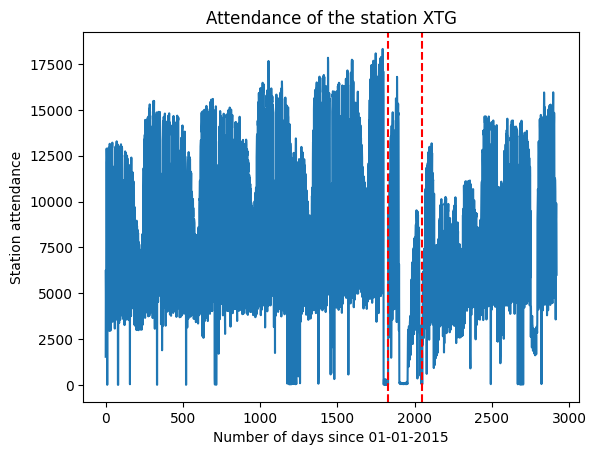

In [ ]:
plt.plot(np.array(df_per_station['XTG']['y']))
plt.axvline(x=1825, color='red', linestyle='--')
plt.axvline(x=2050, color='red', linestyle='--')
plt.title('Attendance of the station XTG')
plt.xlabel('Number of days since 01-01-2015')
plt.ylabel('Station attendance')

In [ ]:
y_array = data.groupby('station')['y'].apply(np.array).to_dict()
print(len(y_array))

439


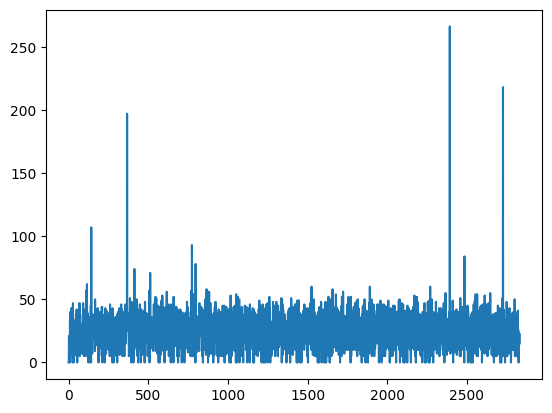

In [ ]:
#y_array['O2O']
#plt.plot(y_array['O2O'])

----
----
# <b> STEP 5: Define X_train and Y_train to train a model </b>

----
## <b> 5.1: Define X_train </b>

In [ ]:
X_train = data[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
print(X_train.head())

TypeError: unhashable type: 'list'

----
## <b> 5.3: Define y_train </b>

In [ ]:
y_train = data['y']
print(y_train.head())
print(y_train.shape)

0     7
1     0
2     9
3     9
4    28
Name: y, dtype: int64
(1229863,)


In [ ]:
# Define the X_train and Y_train
X_train_test, X_val, y_train_test, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = False)

# Reset index to align
X_train_test.reset_index(drop=True, inplace=True)
y_train_test.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

# Create a boolean mask for the filtered condition, now using the reset index
#mask = (data.loc[X_train.index, 'station'] == station_name)

# Apply the mask
#X_train_station = X_train[mask]
#y_train_station = y_train[mask]


#X_train_station = X_train[data['station'] == station_name]
#y_train_station = y_train[data['station'] == station_name]
#X_train, X_val, y_train, y_val = train_test_split(X_train_station, y_train_station, test_size=0.2, random_state=42)


In [ ]:
print(y_val.head())
print(y_val.size)
y_val_station = y_val[data['station'] == 'O2O']
print(type(y_val_station))
print(y_val_station.head())
y_val_station = y_val[data['station'] == 'O2O'].values
print(type(y_val_station))
print(y_val_station[0:5])

0     349
1     445
2    1333
3      17
4     136
Name: y, dtype: int64
245973
<class 'pandas.core.series.Series'>
1         445
424     22404
849      1518
1273     6108
1699     1870
Name: y, dtype: int64
<class 'numpy.ndarray'>
[  445 22404  1518  6108  1870]


----
----
# <b> VALIDATION STEPS </b>

## <b> 1: RANDOM FOREST </b>

### <b> 1.1: WITHOUT LAG </b>

Station 1J7, idx: 1/439
The shape of training is (2470, 8)
The shape of validation is (275, 8)
The MAPE SCORE is : 0.375947311815957


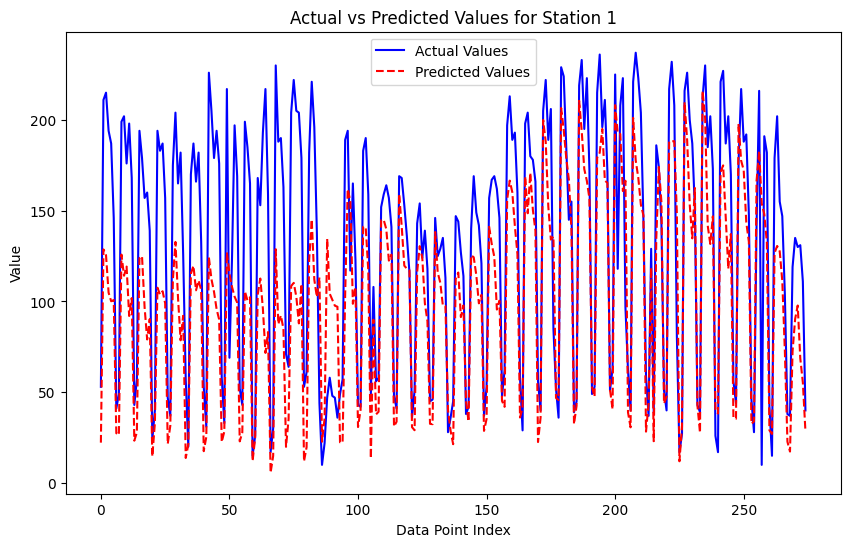

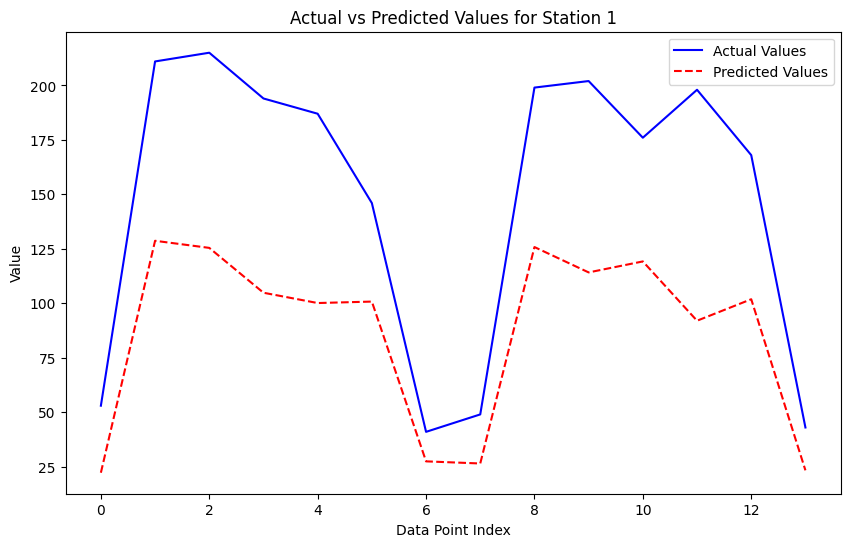

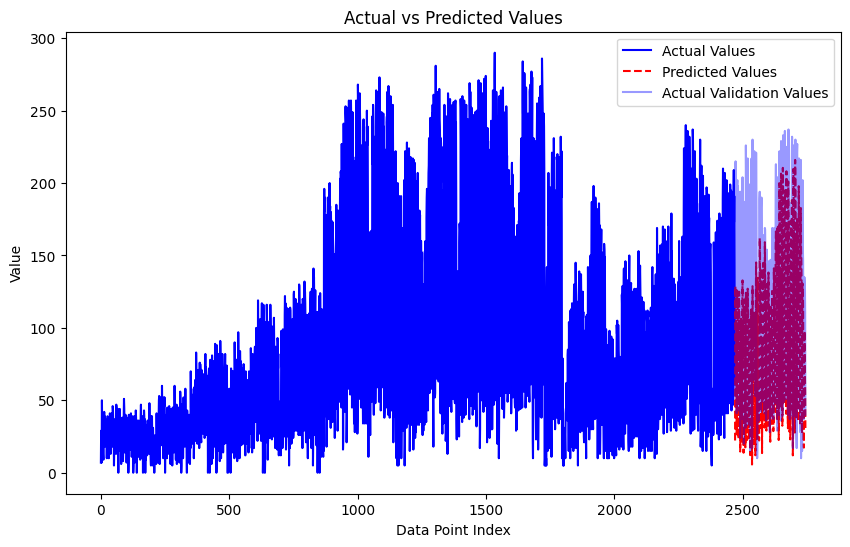

In [ ]:
idx = 1
for name_station,df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Create the validation set
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    base_model = RandomForestRegressor(n_estimators=200)
    base_model.fit(X_train_run, y_train_run)
    y_pred = base_model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.plot(x_axis_pred, y_val_run, label ='Actual Validation Values', color = 'blue', alpha=0.4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  


----
### <b> 1.2 : With Lag </b>

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
idx = 1
for name_station,df in df_per_station_updated.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station_updated.drop(['y','index'])
    y_train_station = df_per_station_lag[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values


    ts_cv = TimeSeriesSplit(
        n_splits=2, 
        gap=180,  
        test_size=180,  
    )

    all_splits = list(ts_cv.split(X_train_station_np, y_train_station_np))
    train_idx, test_idx = all_splits[0]
    X_train_run, X_val_run = X_train_station.iloc[train_idx], X_train_station.iloc[test_idx]
    y_train_run, y_val_run = y_train_station.iloc[train_idx], y_train_station.iloc[test_idx]

    #X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    base_model = RandomForestRegressor(n_estimators=200)
    base_model.fit(X_train_run, y_train_run)
    y_pred = base_model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    x_axis_train = range(len(y_val_run))

    plt.plot(x_axis_train,y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(x_axis_train,y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    x_axis_train = range(len(y_val_run[:14]))

    plt.plot(x_axis_train,y_val_run[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(x_axis_train,y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this if we want to plot for all stations


Station 1J7, idx: 1/439


AttributeError: 'dict' object has no attribute 'drop'

Station 1J7, idx: 1/439
The shape of training is (2470, 16)
The shape of validation is (275, 16)
The MAPE SCORE is : 0.362338242271578


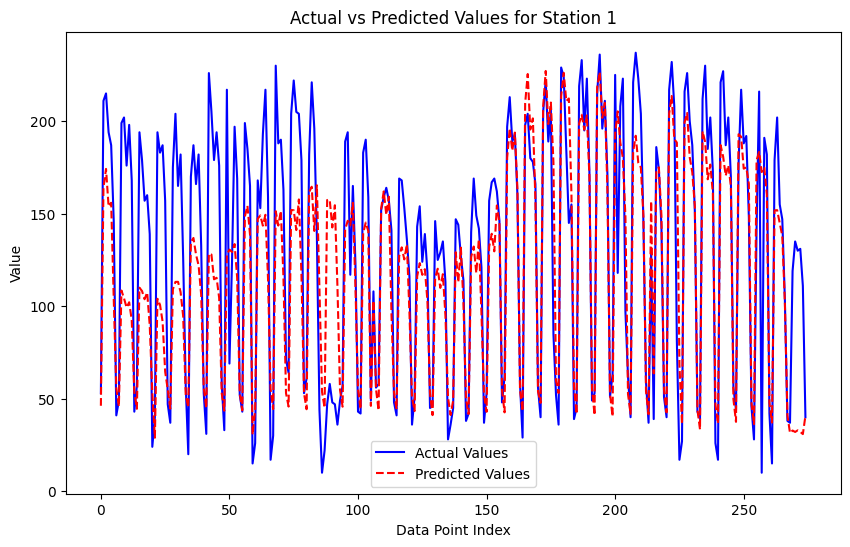

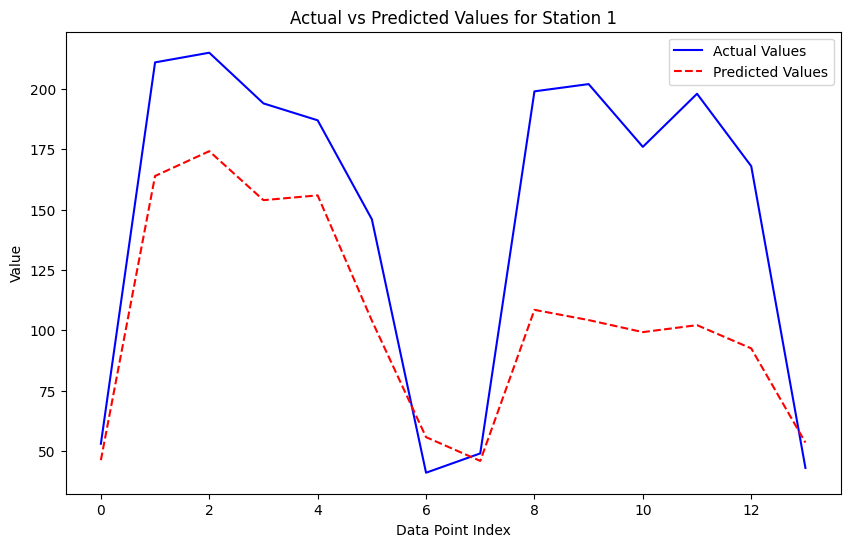

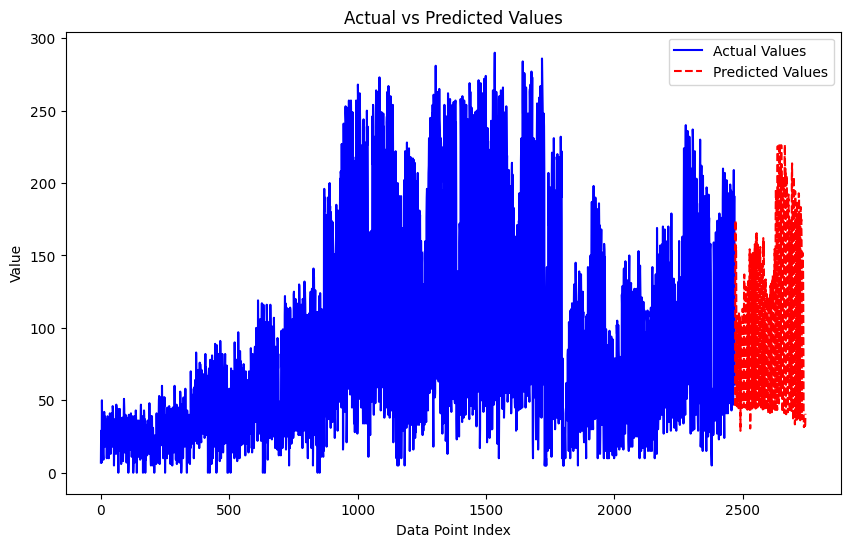

In [ ]:
idx = 1
for name_station,df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2']]
    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min','y_rolling_std7','y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28','y_diff1','y_diff7','month','month_sin','month_cos','quarter','quarter_sin','quarter_cos']]
    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','month','month_sin','month_cos','quarter','quarter_sin','quarter_cos','week_of_year','year']]


    y_train_station = df_per_station[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Create the validation set
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    base_model = RandomForestRegressor(n_estimators=200)
    base_model.fit(X_train_run, y_train_run)
    y_pred = base_model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue') 
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  


In [ ]:
idx = 1
for name_station,df in df_per_station_lag.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2']]
    X_train_station = df_per_station_lag_train[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min','y_rolling_std7','y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28','y_diff1','y_diff7','month','month_sin','month_cos','quarter','quarter_sin','quarter_cos']]
    X_val_station =  df_per_station_lag_val[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    y_train_station = df_per_station_lag[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Create the validation set
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    base_model = RandomForestRegressor(n_estimators=200)
    base_model.fit(X_train_run, y_train_run)
    y_pred = base_model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does

Station 1J7 - The MAPE SCORE is: 0.4058262648264218


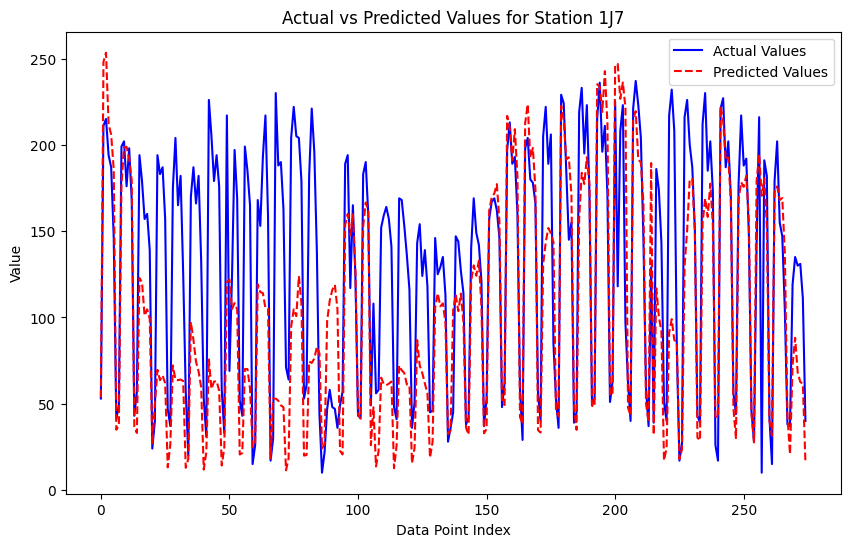

In [ ]:
train_test_split_ratio = 0.9  

df_per_station_train = {}
df_per_station_val = {}

for station, df in df_per_station.items():
    # Ensure sorted by date if not already
    df = df.sort_values(by='date')

    # Splitting data into training and validation sets
    split_index = int(len(df) * train_test_split_ratio)
    df_train = df[:split_index]
    df_val = df[split_index:]

    # Store separated datasets
    df_per_station_train[station] = df_train
    df_per_station_val[station] = df_val

# Now, add lag and other features only to the training sets
for station, df in df_per_station_train.items():
    # Add your feature engineering logic here, similar to what you've provided for the original df_per_station_lag
    # Note: Do not use future information. Only use available data up to the current point in the training dataset

    # Example:
    df['y_lag1'] = df['y'].shift(1)
    # Continue adding features...

    # Drop NaNs after adding new lag and rolling features
    df.dropna(inplace=True)

    # Update the training DataFrame in the dictionary
    df_per_station_train[station] = df

# Your adjusted training and evaluation logic
for name_station in df_per_station_train:
    df_train = df_per_station_train[name_station]
    df_val = df_per_station_val[name_station]

    # Specify features used for training (exclude future information for validation)
    #features = ['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week', 'y_lag1', 'y_lag2', 'y_lag7', 'y_lag28', 'y_lag28_mean', 'y_lag28_max', 'y_lag28_min', 'y_lag7_mean', 'y_lag7_max', 'y_lag7_min', 'y_rolling_std7', 'y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28', 'y_diff1', 'y_diff7', 'month', 'month_sin', 'month_cos', 'quarter', 'quarter_sin', 'quarter_cos']
    features = ['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week', 'y_lag1']

    X_train = df_train[features]
    y_train = df_train['y']

    base_model = RandomForestRegressor(n_estimators=200)
    base_model.fit(X_train, y_train)

    # For validation, predict one step at a time and update lagged features as you go
    y_pred = []
    # Initialize the first lag with the last known value from the training set
    last_known_y = df_train.iloc[-1]['y']

    for index, row in df_val.iterrows():
        # Prepare the features for the current prediction
        # For the first prediction in the validation set, use the last known y from the training set
        if index == df_val.index[0]:
            row['y_lag1'] = last_known_y
        else:
            # For subsequent predictions, update y_lag1 with the last prediction
            row['y_lag1'] = y_pred[-1]

        # Predict the current step
        # Note: row[features].values will not work because row is a Series and does not maintain the column order
        # You need to explicitly select the values in the correct order
        feature_values = [row[feature] for feature in features]
        current_pred = base_model.predict([feature_values])[0]
        y_pred.append(current_pred)

    y_pred = np.array(y_pred)
    y_val = df_val['y'].values  # Actual values for validation

    # Evaluation
    score = mean_absolute_percentage_error(y_val, y_pred)
    print(f"Station {name_station} - The MAPE SCORE is: {score}")

    # Plotting logic here as before, adjusted for the new y_pred and y_val

    # Example plot (simplified)
    plt.figure(figsize=(10, 6))
    plt.plot(y_val, label='Actual Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Break or continue to next station as needed
    break  # Remove or adjust this as per your requirement


----
## <b> 2: XGBOOST </b>

### <b> 2.1: Without Lag </b>

Station 1J7, idx: 1/439
The shape of training is (2470, 8)
The shape of validation is (275, 8)
The MAPE SCORE is : 0.3963463551945364


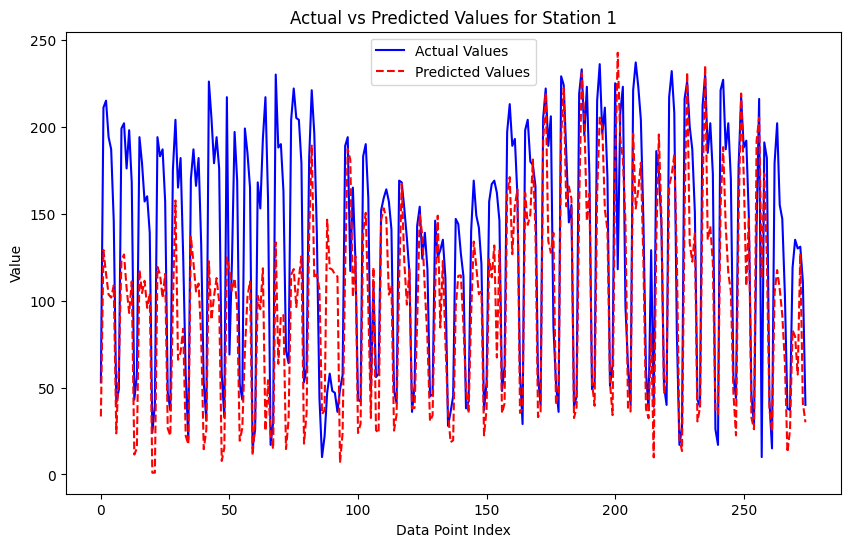

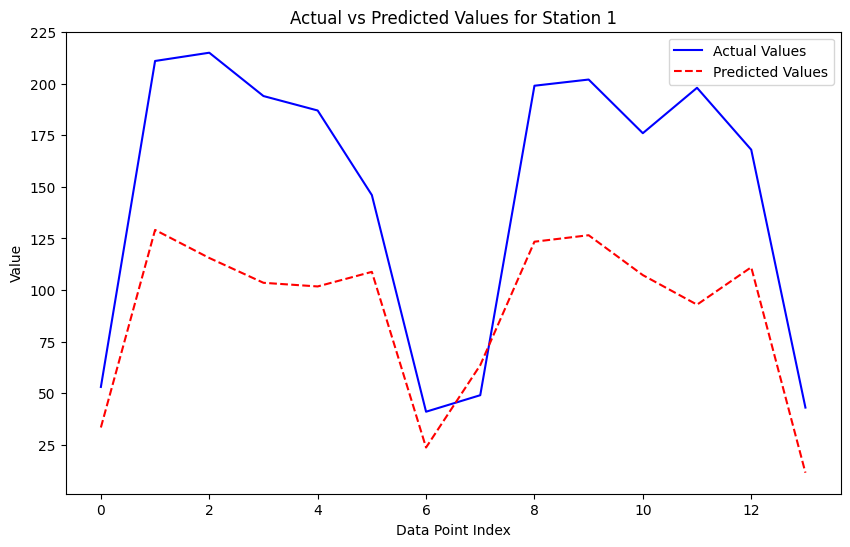

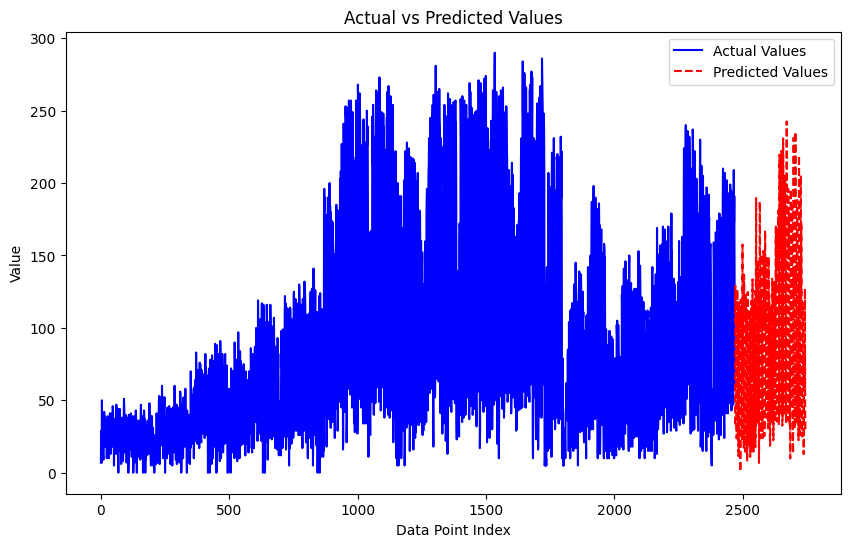

Station O2O, idx: 2/439
The shape of training is (2548, 8)
The shape of validation is (284, 8)
The MAPE SCORE is : 0.3782644668104086


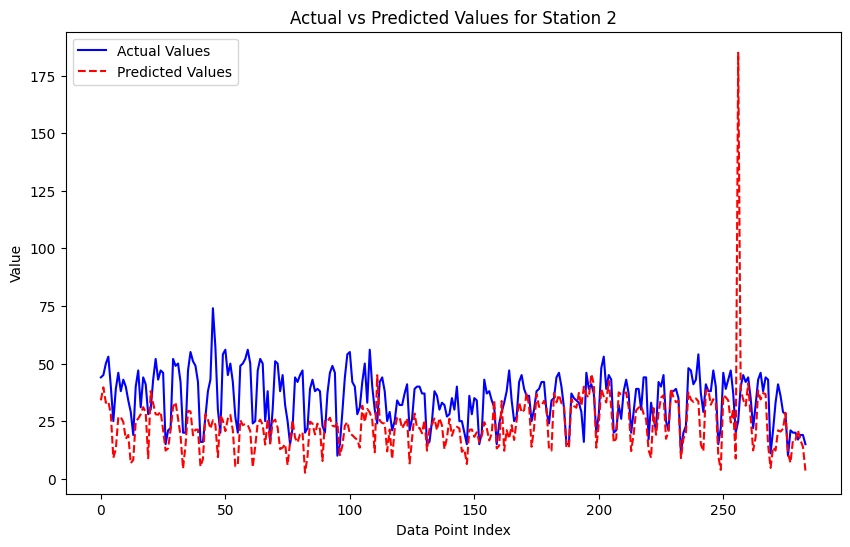

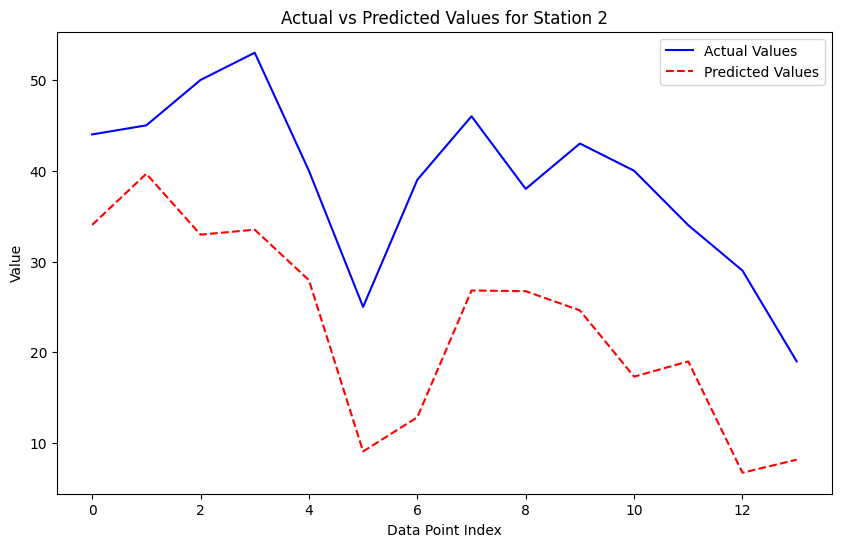

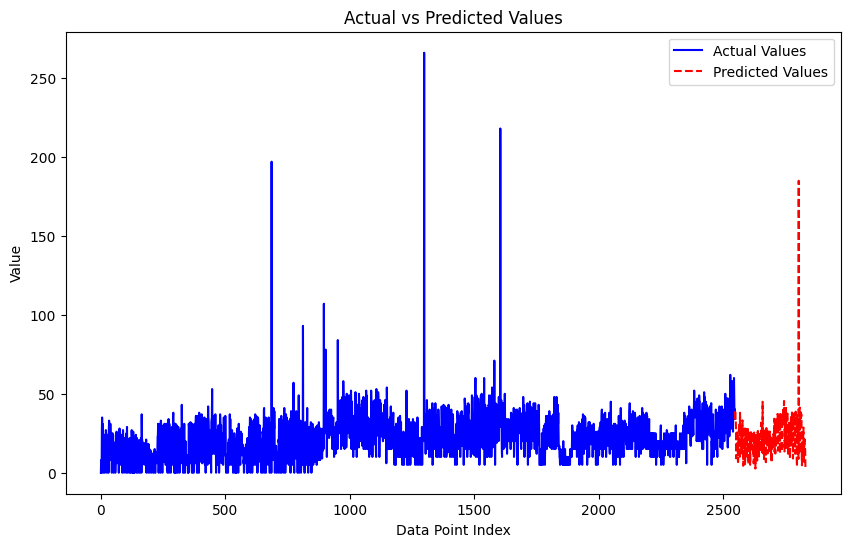

Station 8QR, idx: 3/439
The shape of training is (2568, 8)
The shape of validation is (286, 8)
The MAPE SCORE is : 0.2600304584291729


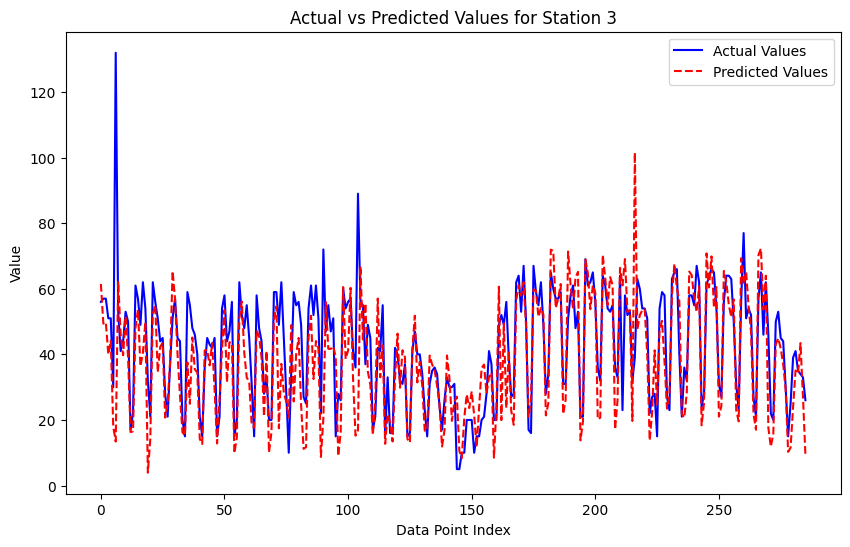

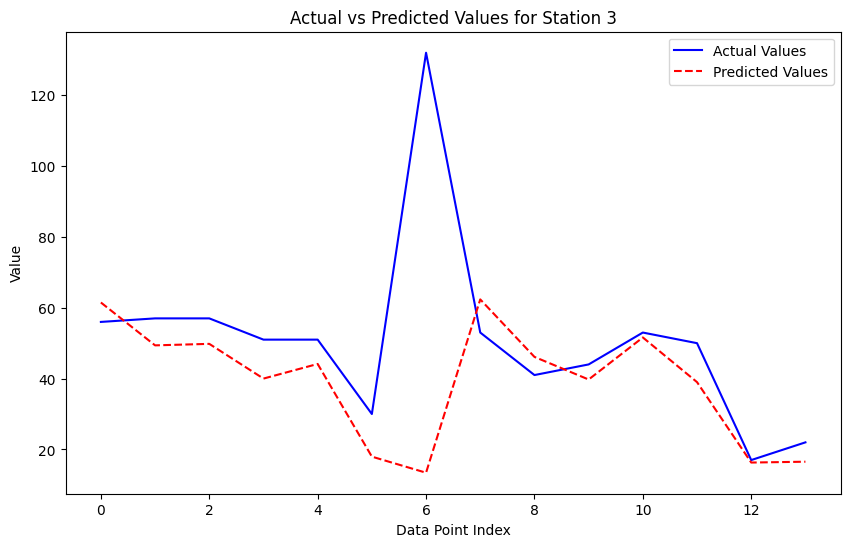

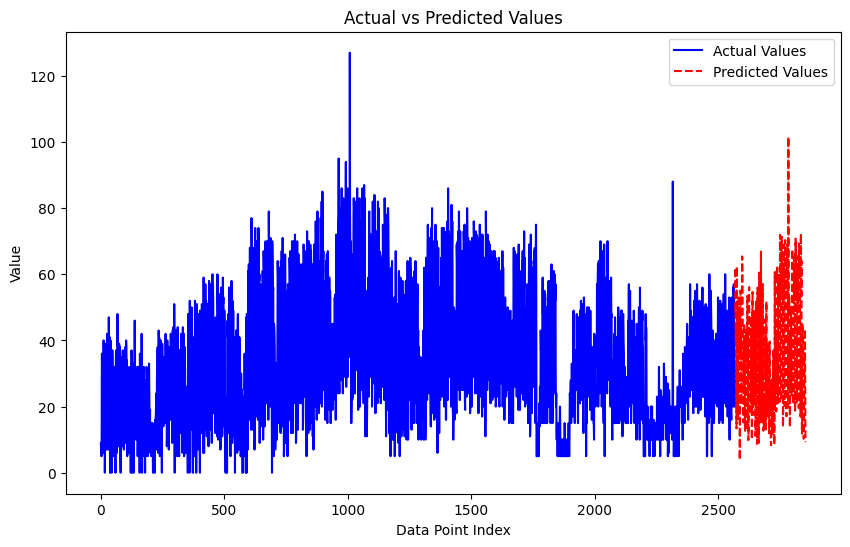

In [ ]:
from xgboost import XGBRegressor

idx = 1
for name_station,df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Create the validation set
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_run, y_train_run)
    y_pred = model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    if idx > 3:
      break  # Remove this if you want to plot for all stations


Station 1J7, idx: 1/439
The shape of training is (2445, 30)
The shape of validation is (272, 30)
The MAPE SCORE is : 0.057639672567456716


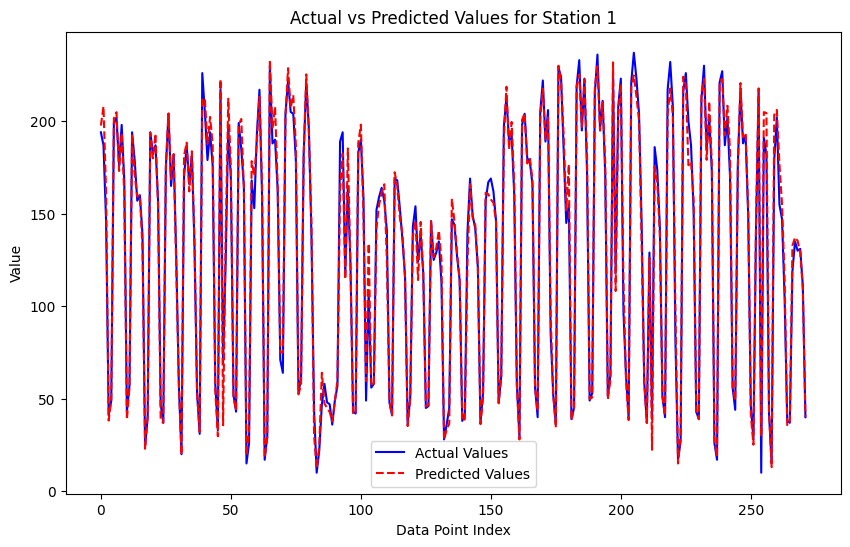

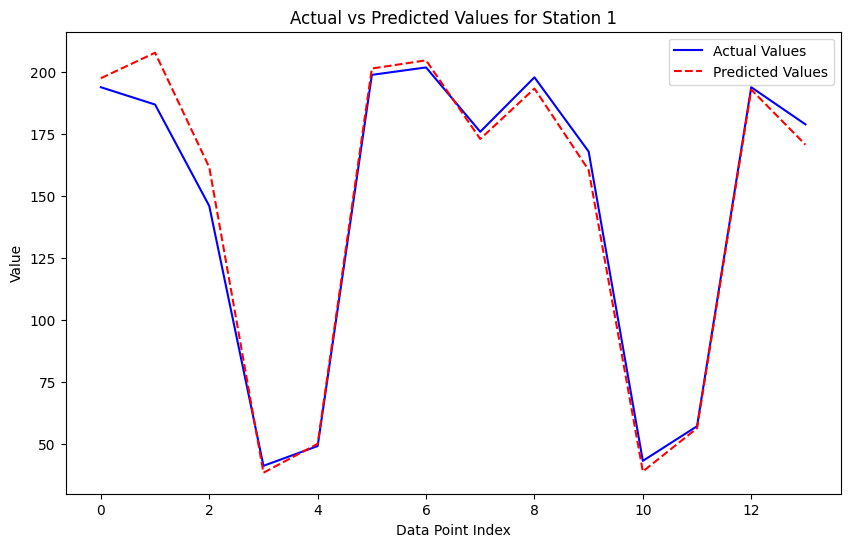

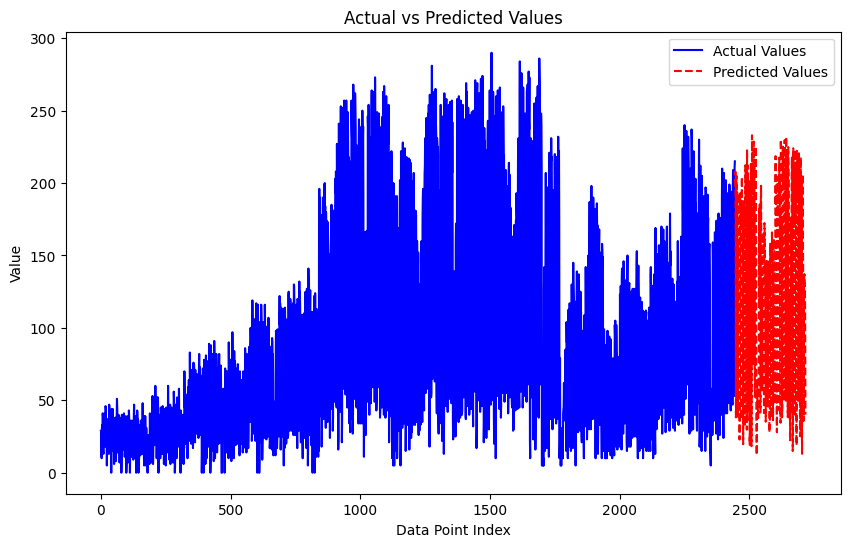

In [ ]:
idx = 1
for name_station,df in df_per_station_lag.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2']]
    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min']]
    X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min','y_rolling_std7','y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28','y_diff1','y_diff7','month','month_sin','month_cos','quarter','quarter_sin','quarter_cos']]

    y_train_station = df_per_station_lag[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Create the validation set
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    model = XGBRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_run, y_train_run)

    y_pred = model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this if you want to plot for all stations


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

for name_station,df in df_per_station_lag.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2']]
    #X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min']]
    X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min','y_rolling_std7','y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28','y_diff1','y_diff7','month','month_sin','month_cos','quarter','quarter_sin','quarter_cos']]

    y_train_station = df_per_station_lag[str(name_station)]['y']
    # Convert to numpy arrays
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Create the validation set
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.1, shuffle = False)
    print(f"The shape of training is {X_train_run.shape}")
    print(f"The shape of validation is {X_val_run.shape}")

    model = XGBRegressor(n_estimators=200, random_state=42)
    model.fit(X_train_run, y_train_run)

    y_pred = model.predict(X_val_run)
    y_pred[y_pred<0] = 1
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"The MAPE SCORE is : {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train_run))
    x_axis_pred = range(len(y_train_run), len(y_train_run) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_run, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this if you want to plot for all stations


----
## <b> 3: ElasticNet </b>

In [ ]:
from sklearn.linear_model import ElasticNet

idx = 1
for name_station in df_per_station.keys():
    print(f"Station{idx}")
    idx += 1

    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    print(type(X_train_station))
    print(type(y_train_station))
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    print(X_train_station_np.shape)
    print(y_train_station_np.shape)

    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.2, shuffle = False)
    # Define ElasticNet model parameters
    # Note: alpha and l1_ratio should be tuned using, for example, cross-validation
    alpha = 0.1  # Regularization strength
    l1_ratio = 0.5  # Mixing parameter, with 0<= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1


    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, tol=0.01)
    model.fit(X_train_run, y_train_run)
    y_pred = base_model.predict(X_val_run)
    #print(y_pred)
    print(y_val_station.head())
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(score)


    # Plotting actual vs predicted values without sorting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this if you want to plot for all stations


In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt

idx = 1
for name_station in df_per_station.keys():
    print(f"Station {name_station}")
    idx += 1
    name_station = '1J7'

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']
    print(type(X_train_station))
    print(type(y_train_station))

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    print(X_train_station_np.shape)
    print(y_train_station_np.shape)

    # Splitting the station-specific data for training and validation
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(
        X_train_station_np, y_train_station_np, test_size=0.2, shuffle=False)

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=31)

    # Parameter grid for ElasticNet
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9, 1.5],
        'max_iter':[10000, 100000, 1000000],
        'tol': [0.01, 0.05, 0.10, 0.20, 0.001, 0.0001 ]
    }

    # Initialize ElasticNet with fixed parameters not being tuned
    model = ElasticNet()

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_run, y_train_run)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_val_run)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    # Evaluation
    score = mean_absolute_percentage_error(y_val_run, y_pred*1.15)
    print(f"MAPE Score: {score}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:14], label='Actual Values', color='blue')
    plt.plot(y_pred[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this to process all stations


In [ ]:
idx = 1
for name_station in df_per_station.keys():
    print(f"Station {name_station}")
    idx += 1
    name_station = '1J7'

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(
        X_train_station_np, y_train_station_np, test_size=0.2, shuffle=False)

    tscv = TimeSeriesSplit(n_splits=14)

    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter':[10000, 100000],
        'tol': [0.01, 0.05, 0.10, 0.20, 0.001, 0.0001]
    }

    model = ElasticNet()

    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    grid_search.fit(X_train_run, y_train_run)
    best_model = grid_search.best_estimator_

    # Recursive Forecasting Setup
    y_pred_recursive = np.zeros(len(X_val_run))
    for i in range(len(X_val_run)):
        current_prediction = best_model.predict(X_val_run[i].reshape(1, -1))
        y_pred_recursive[i] = np.where(current_prediction < 0, 0, current_prediction)
        # Update X_val_run[i+1] with y_pred_recursive[i] if necessary

    score_recursive = mean_absolute_percentage_error(y_val_run, y_pred_recursive)
    print(f"Recursive MAPE Score: {score_recursive}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:7], label='Actual Values', color='blue')
    plt.plot(y_pred_recursive[:7], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1} (Recursive)')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # To process only the first station for demonstration


----
## <b> 4: LSTM </b>

### <b> 4.1: LSTM + ADABOOST </b>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")
    idx += 1

    # Selecting features and target
    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    # Data normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y = y.values.reshape(-1, 1) # Reshaping for scaler
    y_scaled = scaler.fit_transform(y)

    # Creating sequences for LSTM
    time_steps = 10  # Adjust based on your sequence preference
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=33, shuffle=False)

    # Model definition
    #model = Sequential([
    #    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    #    Dense(1)
    #])

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dense(1)
    ])

    # Model compilation
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Model training
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

    # Prediction
    y_pred = model.predict(X_test)

    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)

    score = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    print(f"MAPE Score: {score}")


    from sklearn.ensemble import AdaBoostRegressor

    # Generate LSTM predictions for AdaBoost input
    X_train_lstm_pred = model.predict(X_train).reshape(-1, 1)
    X_test_lstm_pred = model.predict(X_test).reshape(-1, 1)

    # Train AdaBoost model using LSTM predictions as features
    ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=1.0, loss='linear')
    ada_model.fit(X_train_lstm_pred, y_train.ravel())

    # AdaBoost predictions
    y_val_ada_pred = ada_model.predict(X_test_lstm_pred)

    # Inverse transform the predictions
    y_val_ada_pred_inverse = scaler.inverse_transform(y_val_ada_pred.reshape(-1, 1))
    y_val_actual_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation
    score_ada = mean_absolute_percentage_error(y_val_actual_inverse, y_val_ada_pred_inverse)
    print(f'AdaBoost MAPE Score: {score_ada}%')

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[60:67], label='Actual Values', color='blue')
    plt.plot(y_pred_actual[60:67], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_actual_inverse[60:67], label='Actual Values', color='blue')
    plt.plot(y_val_ada_pred_inverse[60:67], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    if idx > 3:
        break


----
### <b> 4.2: Only LSTM </b>

Station 1J7
Epoch 1/20
31/31 [==============================] - 15s 103ms/step - loss: 0.1097 - val_loss: 0.0307
Epoch 2/20
31/31 [==============================] - 1s 34ms/step - loss: 0.0804 - val_loss: 0.0214
Epoch 3/20
31/31 [==============================] - 1s 35ms/step - loss: 0.0706 - val_loss: 0.0121
Epoch 4/20
31/31 [==============================] - 1s 35ms/step - loss: 0.0632 - val_loss: 0.0218
Epoch 5/20
31/31 [==============================] - 1s 34ms/step - loss: 0.0602 - val_loss: 0.0131
Epoch 6/20
31/31 [==============================] - 1s 34ms/step - loss: 0.0583 - val_loss: 0.0149
Epoch 7/20
31/31 [==============================] - 1s 44ms/step - loss: 0.0584 - val_loss: 0.0231
Epoch 8/20
31/31 [==============================] - 1s 44ms/step - loss: 0.0590 - val_loss: 0.0113
Epoch 9/20
31/31 [==============================] - 1s 45ms/step - loss: 0.0584 - val_loss: 0.0124
Epoch 10/20
31/31 [==============================] - 1s 37ms/step - loss: 0.0572 - val_loss: 0.

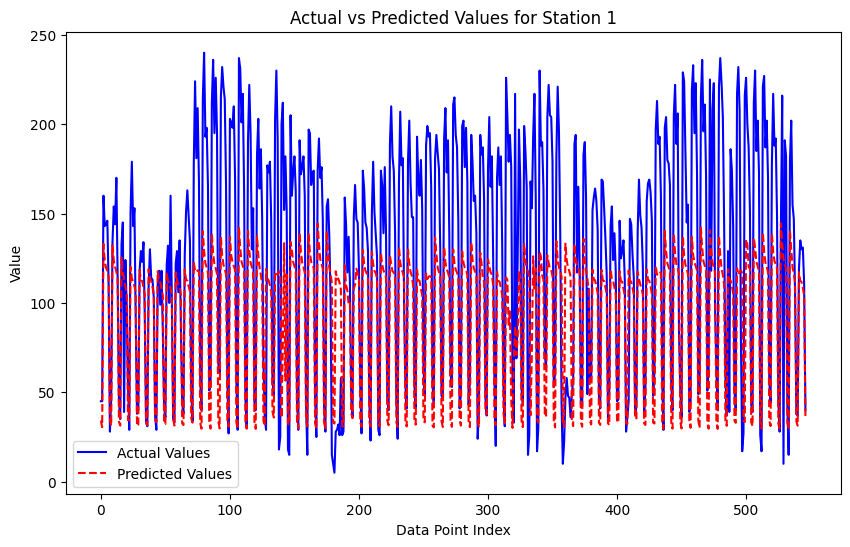

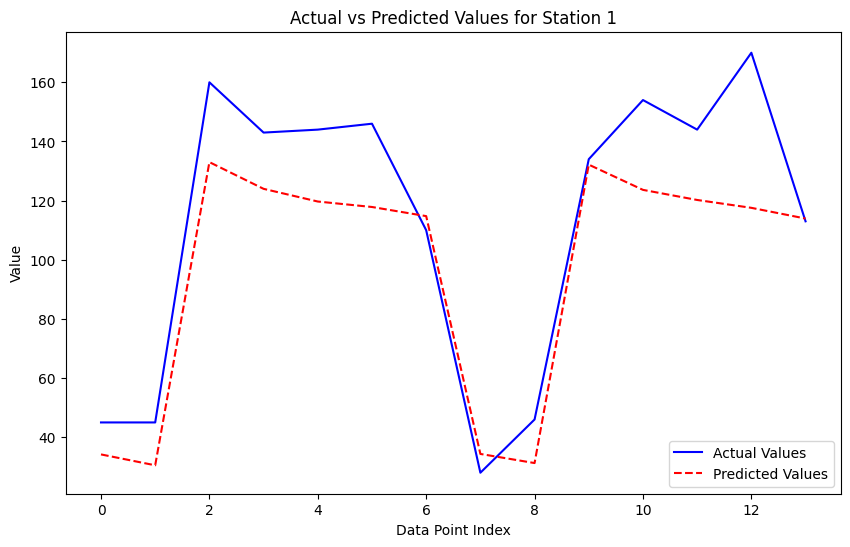

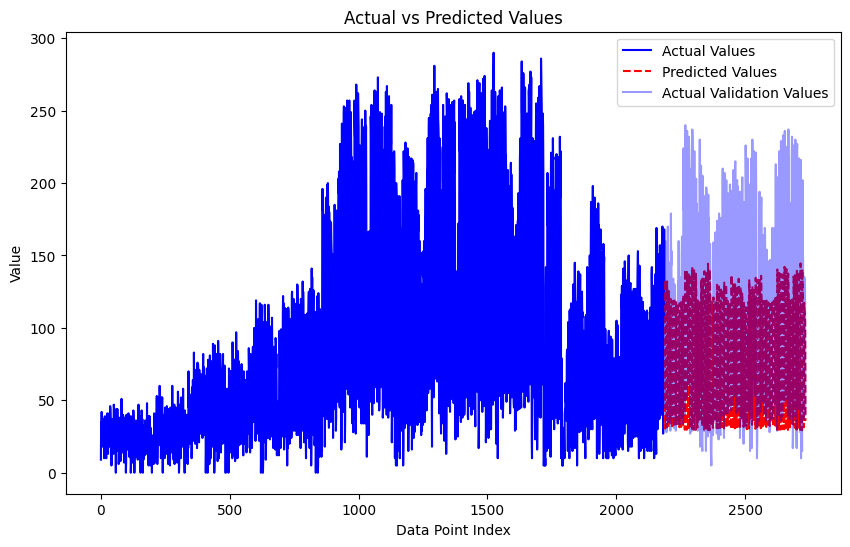

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dropout, Dense, Conv1D, MaxPooling1D,
                                     Flatten, Bidirectional, BatchNormalization)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")
    idx += 1

    # Selecting features and target
    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    # Data normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y = y.values.reshape(-1, 1) # Reshaping for scaler
    y_scaled = scaler.fit_transform(y)

    # Creating sequences for LSTM
    time_steps = 10  # Adjust based on your sequence preference
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=33, shuffle=False)

    # Model definition
    #model = Sequential([
    #    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    #    Dense(1)
    #])

    # model = Sequential([
    #     LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    #     Dropout(0.2),
    #     LSTM(100, return_sequences=True),
    #     Dropout(0.2),
    #     LSTM(50),
    #     Dense(1)
    # ])

    model = Sequential([
        # Conv1D layer for capturing temporal autocorrelations; input_shape is only needed for the first layer.
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # It's common to flatten the data after convolutional and pooling layers when transitioning to fully connected layers,
        # but since we want to preserve the temporal structure for LSTM, we skip flattening here.

        # LSTM layers
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),  # return_sequences is False by default, so it returns the last output in the output sequence

        # Fully connected layer
        Dense(50, activation='relu'),
        Dropout(0.2),

        # Output layer
        Dense(1)
    ])

    # model = Sequential([
    #     # Convolutional Layer
    #     Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    #     BatchNormalization(),
    #     MaxPooling1D(pool_size=2),
    #     Dropout(0.3),

    #     # Second Convolutional Layer
    #     Conv1D(filters=128, kernel_size=3, activation='relu'),
    #     BatchNormalization(),
    #     MaxPooling1D(pool_size=2),
    #     Dropout(0.3),

    #     # Bidirectional LSTM Layer
    #     Bidirectional(LSTM(50, return_sequences=True)),
    #     Dropout(0.3),

    #     # Second Bidirectional LSTM Layer
    #     Bidirectional(LSTM(100, return_sequences=True)),
    #     Dropout(0.3),

    #     # Third Bidirectional LSTM Layer
    #     Bidirectional(LSTM(50)),
    #     Dropout(0.3),

    #     # Fully Connected Layer
    #     Dense(100, activation='relu'),
    #     Dropout(0.3),

    #     # Output Layer
    #     Dense(1)
    # ])

    # Model compilation
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Model training
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

    # Prediction
    y_pred = model.predict(X_test)

    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_train_actual = scaler.inverse_transform(y_train)

    score = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    print(f"MAPE Score: {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred_actual[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train))
    x_axis_pred = range(len(y_train), len(y_train) + len(y_pred_actual))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_actual, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.plot(x_axis_pred, y_test_actual, label='Actual Validation Values', color = 'blue', alpha = 0.4)
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create sequences from the dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Example station data initialization
# Ensure df_per_station is initialized with your actual data

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    time_steps = 10
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

    # Enhanced Model Definition
    #model = Sequential([
    #    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    #    Dropout(0.3),
    #    LSTM(256, return_sequences=True),
    #    Dropout(0.3),
    #    LSTM(128, return_sequences=False),
    #    Dense(64, activation='relu'),
    #    Dropout(0.3),
    #    Dense(1)
    #])

        # Hybrid CNN-LSTM Model Definition
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])


    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_test)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred)

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    score = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    print(f"Enhanced MAPE Score: {score}%")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[:7], label='Actual Values', color='blue')
    plt.plot(y_pred_actual[:7], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Enhanced Model Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    if idx > 1:  # Adjust as necessary for demonstration or full execution
        break


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import AdaBoostRegressor
import matplotlib.pyplot as plt

# Function to create dataset sequences
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    # Selecting features and target
    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    # Data normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    # Creating sequences for LSTM
    time_steps = 10  # Adjust based on your sequence preference
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=33, shuffle=False)

    # Model definition
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dense(1)
    ])

    # Model compilation
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Model training
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

    # Prediction
    y_pred = model.predict(X_test)

    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred)

    # Evaluation
    score = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    print(f"LSTM MAPE Score: {score}%")

    # AdaBoost using LSTM predictions as features
    X_train_lstm_pred = model.predict(X_train).reshape(-1, 1)
    X_test_lstm_pred = model.predict(X_test).reshape(-1, 1)

    base_estimator = DecisionTreeRegressor(max_depth=100)
    model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=140, learning_rate=0.01, loss='linear')

    ada_model = AdaBoostRegressor(n_estimators=100, learning_rate=1.0, loss='linear')
    ada_model.fit(X_train_lstm_pred, y_train.ravel())

    y_test_ada_pred = ada_model.predict(X_test_lstm_pred)
    y_test_ada_pred_inverse = scaler.inverse_transform(y_test_ada_pred.reshape(-1, 1))

    # AdaBoost Evaluation
    score_ada = mean_absolute_percentage_error(y_test_actual, y_test_ada_pred_inverse)
    print(f'AdaBoost MAPE Score: {score_ada}%')

    # Visualization for LSTM
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[:7], label='Actual Values', color='blue')
    plt.plot(y_pred_actual[:7], label='LSTM Predicted Values', color='red', linestyle='--')
    plt.title(f'LSTM Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Visualization for AdaBoost
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[:7], label='Actual Values', color='blue')
    plt.plot(y_test_ada_pred_inverse[:7], label='AdaBoost Predicted Values', color='red', linestyle='--')
    plt.title(f'AdaBoost Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    idx += 1
    if idx > 3:  # Limiting to 3 stations for demonstration
        break



----
## <b> 5: Ensemble Learning </b>

In [ ]:
from lightgbm import LGBMRegressor
import xgboost as xgb
i
idx = 1
for name_station in df_per_station.keys():
    print(f"Station {name_station}")
    idx += 1

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    # Splitting the data
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(
        X_train_station_np, y_train_station_np, test_size=0.2, shuffle=False)

    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=62)  # Adjust splits for computational efficiency

    # ElasticNet
    param_grid_elasticnet = {
        'alpha': [0.01, 0.1, 1],
        'l1_ratio': [0.1, 0.5, 0.9],
    }

    # AdaBoost
    param_grid_adaboost = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    }

    # RandomForest
    param_grid_rf = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None]
    }



    # XGBoost
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [6, 10],
    }

    # Models setup
    models = {
        'ElasticNet': (ElasticNet(), param_grid_elasticnet),
        'AdaBoost': (AdaBoostRegressor(), param_grid_adaboost),
        'RandomForest': (RandomForestRegressor(), param_grid_rf),
        'XGBoost': (xgb.XGBRegressor(objective='reg:squarederror'), param_grid_xgb)
    }

    predictions = []

    for model_name, (model, param_grid) in models.items():
        print(f"Training {model_name}...")
        grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', verbose=1)
        grid_search.fit(X_train_run, y_train_run)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val_run)
        predictions.append(y_pred)

        # Evaluate each model
        score = mean_absolute_percentage_error(y_val_run, y_pred)
        print(f"{model_name} MAPE Score: {score}")

    # Final Predictions as the mean of all model predictions
    y_pred_final = np.mean(predictions, axis=0)

    # Final Evaluation
    score_final = mean_absolute_percentage_error(y_val_run, y_pred_final)
    print(f"Final MAPE Score (Mean of All Predictions): {score_final}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:31], label='Actual Values', color='blue')
    plt.plot(y_pred_final[:31], label='Mean Predicted Values', color='green', linestyle='--')
    plt.title(f'Actual vs Mean Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Process only the first station for demonstration; remove this to process all stations


----
----
# <b> TEST STEPS / CREATE TEST CSV </b>

## <b> 1: ELASTIC NET </b>

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt

idx = 1
y_test = create_y_test(x_test)
for name_station,df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']
    X_test_station = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    print(type(X_train_station))
    print(type(y_train_station))

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    X_test_station_np = X_test_station.values

    print(X_train_station_np.shape)
    print(y_train_station_np.shape)
    print(X_test_station_np.shape)

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=14)

    # Parameter grid for ElasticNet
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9, 1.5],
        'max_iter':[4000, 10000, 100000],
        'tol': [0.01, 0.05, 0.10, 0.20, 0.001, 0.0001 ]
    }

    # Initialize ElasticNet with fixed parameters not being tuned
    model = ElasticNet()

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_station_np, y_train_station_np)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_test_station_np)
    y_pred = np.where(y_pred < 0, 1, y_pred)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

    # Generate an x-axis for y_train_station_np
    x_axis_train = range(len(y_train_station_np))

    # Generate an x-axis for y_pred that starts right after the last index of y_train_station_np
    x_axis_pred = range(len(y_train_station_np), len(y_train_station_np) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_station_np, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break

y_test.to_csv(f'XGBOOST_predictions.csv', index=False)



Station 1J7, idx: 1/439
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(2745, 8)
(2745,)
(175, 8)
Fitting 14 folds for each of 288 candidates, totalling 4032 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1008 fits failed out of a total of 4032.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1008 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 892, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
# Initialize lists to store metrics or any other performance measures if needed
metrics = []

# Train the model for each station
idx = 1
for name_station in y_array:  
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    # Select data for the current station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]

    # Define ElasticNet model parameters
    # Note: alpha and l1_ratio should be tuned using, for example, cross-validation
    alpha = 0.1  # Regularization strength
    l1_ratio = 0.5  # Mixing parameter, with 0<= l1_ratio <= 1. l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1

    # Initialize the ElasticNet model
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, tol=0.01)

    # Train the model
    model.fit(X_train_station, y_train_station)

    # Predict
    predictions = model.predict(X_test_station)

    # Compute and store the RMSE for this station
    rmse = np.sqrt(mean_squared_error(y_test[y_test['index'].str.contains(name_station)]['y'], predictions))
    metrics.append(rmse)

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Print average RMSE across all stations (or other metrics as needed)
average_rmse = np.mean(metrics)
print(f"Average RMSE across all stations: {average_rmse}")

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_elasticnet_Kaggle_BI.csv', index=False)


----
## <b> 2: LSTM </b>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create sequences from the dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Example station data initialization
# Ensure df_per_station is initialized with your actual data

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    time_steps = 10
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)


    # Enhanced Model Definition
    #model = Sequential([
    #    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    #    Dropout(0.3),
    #    LSTM(256, return_sequences=True),
    #    Dropout(0.3),
    #    LSTM(128, return_sequences=False),
    #    Dense(64, activation='relu'),
    #    Dropout(0.3),
    #    Dense(1)
    #])

    # Hybrid CNN-LSTM Model Definition
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])


    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_seq, y_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    predictions = outputs.numpy().flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(y, label='Actual Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Enhanced Model Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_deep_Kaggle_BI.csv', index=False)

In [ ]:
y_test = create_y_test(x_test)

            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dropout, Dense, Conv1D, MaxPooling1D,
                                     Flatten, Bidirectional, BatchNormalization)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")
    idx += 1

    # Selecting features and target
    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']
    X_test = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]


    # Data normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y = y.values.reshape(-1, 1) # Reshaping for scaler
    y_scaled = scaler.fit_transform(y)
    X_test_scaled = scaler.fit_transform(X_test)

    # Creating sequences for LSTM
    time_steps = 10  # Adjust based on your sequence preference
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)

    model = Sequential([
        # Conv1D layer for capturing temporal autocorrelations; input_shape is only needed for the first layer.
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        # LSTM layers
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),  # return_sequences is False by default, so it returns the last output in the output sequence

        # Fully connected layer
        Dense(50, activation='relu'),
        Dropout(0.2),

        # Output layer
        Dense(1)
    ])

    # Model compilation
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Model training
    history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)

    # Prediction
    y_pred = model.predict(X_test)

    # Inverse transform to get actual values
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    y_train_actual = scaler.inverse_transform(y_train)

    score = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    print(f"MAPE Score: {score}")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_actual[:14], label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred_actual[:14], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    x_axis_train = range(len(y_train))
    x_axis_pred = range(len(y_train), len(y_train) + len(y_pred_actual))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_actual, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break


NameError: name 'df_per_station' is not defined

----
### GOOD ?

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten, Bidirectional, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")
    idx += 1

    # Selecting features and target for training
    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    # Test set
    X_test = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    print()

    # Data normalization
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Reshaping for scaler

    # Creating sequences for LSTM
    time_steps = 175  # Adjust based on your sequence preference
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)

    # Adjusting the input shape for the model based on the time_steps and number of features
    input_shape = (X_seq.shape[1], X_seq.shape[2])

    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    # Fitting the model
    history = model.fit(X_seq, y_seq, epochs=2, batch_size=16, verbose=1)

    # Preparing the test set
    X_test_scaled = scaler_X.transform(X_test)  # Use transform to ensure consistency
    X_test_seq = create_dataset(pd.DataFrame(X_test_scaled), pd.DataFrame(np.zeros(len(X_test_scaled))), time_steps)[0]

    # Prediction
    y_pred = model.predict(X_test_seq)
    #y_pred = model.predict(X_test_scaled)


    # Inverse transform to get actual values for y_pred
    y_pred_actual = scaler_y.inverse_transform(y_pred)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred_actual

    # Generate an x-axis for y_train_station_np
    x_axis_train = range(len(y))

    # Generate an x-axis for y_pred that starts right after the last index of y_train_station_np
    x_axis_pred = range(len(y), len(y) + len(y_pred_actual))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    break

y_test.to_csv(f'{name_station}_predictions.csv', index=False)


Station 1J7

Epoch 1/2
161/161 [==============================] - 12s 24ms/step - loss: 0.0863
Epoch 2/2
161/161 [==============================] - 3s 22ms/step - loss: 0.0740


ValueError: Expected input data to be non-empty.

In [ ]:
print(len(y_pred_actual))
print(len(y_test[y_test['index'].str.contains(name_station)]))

165
175


In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


y_test = create_y_test(x_test)  
# Scaling features
scaler = MinMaxScaler(feature_range=(0, 1))

# Prepare a DataFrame to collect predictions
predictions = pd.DataFrame()

idx = 1

for name_station, df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    # Preparing dataset
    X_train_station = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df['y']
    X_test_station = df_per_station_test[name_station][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train_station)
    X_test_scaled = scaler.transform(X_test_station)

    # Reshape for LSTM layer: [samples, time steps, features]
    X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    # Define model
    # model = Sequential([
    #     LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    #     Conv1D(filters=64, kernel_size=1, activation='relu'),
    #     MaxPooling1D(pool_size=1),
    #     Flatten(),
    #     Dense(50, activation='relu'),
    #     Dense(1)
    # ])

    model = Sequential([
        # LSTM layer for capturing long-term dependencies
        LSTM(units=64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(0.2),

        # Conv1D layer for extracting spatial features from the sequence
        Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),

        # GRU layer for capturing information over sequences efficiently
        GRU(units=64, return_sequences=False),
        Dropout(0.2),

        # Flattening the outputs for the dense layers
        Flatten(),

        # Dense layers for prediction
        Dense(units=100, activation='relu'),
        Dropout(0.2),
        Dense(units=1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')

    # Fit model
    history = model.fit(X_train_scaled, y_train_station, epochs=100, batch_size=72, validation_split=0.2, callbacks=[early_stopping], verbose=2)

    # Predict
    y_pred = model.predict(X_test_scaled).flatten()

    # Store predictions
    #predictions[name_station] = y_pred

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

    x_axis_train = range(len(y_train_station.values))

    x_axis_pred = range(len(y_train_station.values), len(y_train_station.values) + len(y_pred))

y_test.to_csv('/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/y_test_with_predictions.csv', index=False)


NameError: name 'create_y_test' is not defined

----
## <b> 3: XGBOOST </b>

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler  



# Process each station
idx = 1
y_test = create_y_test(x_test)
for name_station, df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    # Extract features and target variable as before
    X_train_station = df[['week_of_year', 'month', 'month_sin', 'month_cos', 'quarter','quarter_sin', 'quarter_cos','job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df['y']
    X_test_station = df_per_station_test[str(name_station)][['week_of_year', 'month', 'month_sin', 'month_cos', 'quarter','quarter_sin', 'quarter_cos','job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=14)

    # Parameter grid for SVR
    param_grid = {
        'svr__C': [0.1, 1, 10],
        'svr__epsilon': [0.01, 0.1],
        'svr__kernel': ['rbf']  # Consider experimenting with different kernels
    }

    # Create a pipeline that scales the data then applies SVR
    pipeline = make_pipeline(StandardScaler(), SVR())

    # GridSearchCV setup
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_station, y_train_station)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_test_station)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

# Save predictions
y_test.to_csv(f'/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/SVR_predictions.csv', index=False)


            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0
Station 1J7, idx: 1/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station O2O, idx: 2/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station 8QR, idx: 3/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station UMC, idx: 4/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station FK3, idx: 5/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station I1K, idx: 6/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station KY6, idx: 7/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station V8D, idx: 8/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station EK4, idx: 9/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station 357, idx: 10/439
Fitting 14 folds for each of 6 candidates, totalling 84 fits
Station O7B, idx: 11/43

In [ ]:
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt

idx = 1
y_test = create_y_test(x_test)
for name_station,df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station[str(name_station)][['week_of_year', 'month', 'month_sin', 'month_cos', 'quarter','quarter_sin', 'quarter_cos','job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']
    X_test_station = df_per_station_test[str(name_station)][['week_of_year', 'month', 'month_sin', 'month_cos', 'quarter','quarter_sin', 'quarter_cos','job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    X_test_station_np = X_test_station.values

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=14)

    # Parameter grid for XGBoost
    param_grid = {
        'n_estimators': [200],
        'learning_rate': [0.01, 0.1],
    }

    model = XGBRegressor()

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_station_np, y_train_station_np)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_test_station_np)
    y_pred = np.where(y_pred < 0, 1, y_pred)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

y_test.to_csv(f'/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/XGBOOST_predictions.csv', index=False)



            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0
Station 1J7, idx: 1/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station O2O, idx: 2/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station 8QR, idx: 3/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station UMC, idx: 4/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station FK3, idx: 5/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station I1K, idx: 6/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station KY6, idx: 7/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station V8D, idx: 8/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station EK4, idx: 9/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station 357, idx: 10/439
Fitting 14 folds for each of 2 candidates, totalling 28 fits
Station O7B, idx: 11/43

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

idx = 1
y_test = create_y_test(x_test)
for name_station,df in df_per_station_lag.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    # Selecting the target variable
    #y_train = df['y','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min','y_rolling_std7','y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28','y_diff1','y_diff7'].values  
    y_train = df['y']
    y_test_t = df_per_station_test[str(name_station)]['y'].values  # Make sure this is correctly aligned with your data

    # Auto ARIMA model to find optimal parameters (p,d,q)
    auto_arima_model = pm.auto_arima(y_train, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_order=None, trace=True)

    # Extract the best ARIMA order
    order = auto_arima_model.order
    print(f"Best ARIMA Order for Station {name_station}: {order}")

    # Fit ARIMA model with the best found parameters
    model = ARIMA(y_train, order=order)
    model_fit = model.fit()

    # Forecast
    # The number of steps to forecast is the length of your test set
    forecast_steps = len(y_test_t)
    forecast = model_fit.forecast(steps=forecast_steps)


    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = forecast

y_test.to_csv(f'/content/drive/MyDrive/MVA-2023-2024/SNCF-MALLAT/ARIMA_predictions.csv', index=False)



            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0
Station 1J7, idx: 1/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29128.758, Time=11.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30797.469, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30794.825, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30226.740, Time=3.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30795.469, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29475.689, Time=4.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29349.624, Time=4.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29336.831, Time=10.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=29212.271, Time=11.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=29849.772, Time=3.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=29341.267, Time=6.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29349.810, Time=7.13 sec


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Station O2O, idx: 2/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22021.546, Time=3.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=23377.796, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=23075.429, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22195.418, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=23375.796, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22061.567, Time=3.41 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=22043.705, Time=2.42 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=22044.098, Time=3.85 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=22004.981, Time=9.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22038.660, Time=3.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=21871.630, Time=8.26 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=21691.732, Time=9.96 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=22042.776, Time=2.45 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=21757.800, Time=11.4

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Station 8QR, idx: 3/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23584.014, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24893.527, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24838.432, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24154.314, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24891.527, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23647.647, Time=1.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23590.289, Time=2.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23584.914, Time=3.68 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23433.095, Time=5.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23556.659, Time=2.48 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=23163.607, Time=9.27 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=22582.967, Time=8.41 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=22853.171, Time=10.13 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=22475.734, Time=11.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

Station UMC, idx: 4/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=28457.533, Time=3.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=29944.832, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=29945.677, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=29635.387, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=29942.832, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=28762.075, Time=1.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=28660.151, Time=4.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=28647.379, Time=5.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=28444.416, Time=4.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=28650.212, Time=5.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=28289.717, Time=9.92 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=27344.499, Time=10.72 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=27488.394, Time=7.57 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=27190.316, Time=11.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Station FK3, idx: 5/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34608.180, Time=6.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=36198.145, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=36200.140, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=36200.112, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=36196.146, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=34940.944, Time=2.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=34850.951, Time=2.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=34182.256, Time=9.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=34940.848, Time=5.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=34528.299, Time=10.20 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=34635.189, Time=15.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=34652.644, Time=8.73 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=34378.044, Time=9.52 sec

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integ

Station I1K, idx: 6/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=29397.269, Time=3.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=30866.614, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30856.464, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30415.725, Time=1.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=30864.615, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=29666.624, Time=3.58 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=29606.197, Time=2.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=29577.183, Time=5.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=29431.937, Time=7.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30009.699, Time=2.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=29557.669, Time=3.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=29608.195, Time=2.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=29147.993, Time=11.60 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=28248.273, Time=10.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

Station KY6, idx: 7/439
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=48340.971, Time=7.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49656.700, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=49657.231, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=49328.802, Time=1.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49654.701, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=48406.647, Time=3.93 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=48347.031, Time=5.74 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=48311.034, Time=5.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=48349.008, Time=5.34 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=47071.674, Time=10.20 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=47914.065, Time=4.55 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=46574.091, Time=7.10 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=46999.353, Time=6.35 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=46429.269, Time=11.

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split

idx = 1
for name_station,df in df_per_station_lag.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station_lag[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week','y_lag1','y_lag2','y_lag7','y_lag28','y_lag28_mean','y_lag28_max','y_lag28_min','y_lag7_mean','y_lag7_max','y_lag7_min','y_rolling_std7','y_rolling_std28', 'y_ewm_alpha_7', 'y_ewm_alpha_28','y_diff1','y_diff7','month','month_sin','month_cos','quarter','quarter_sin','quarter_cos']]
    y_train_station = df_per_station_lag[str(name_station)]['y']
    X_test_station = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    X_test_station_np = X_test_station.values

    print(X_train_station_np.shape)
    print(y_train_station_np.shape)
    print(X_test_station_np.shape)

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=14)

    # Parameter grid for XGBoost
    param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [6, 10],
    }

    # Initialize XGboost with fixed parameters not being tuned
    model = XGBRegressor()

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_station_np, y_train_station_np)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_test_station_np)
    y_pred = np.where(y_pred < 0, 1, y_pred)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

    # Generate an x-axis for y_train_station_np
    x_axis_train = range(len(y_train_station_np))

    # Generate an x-axis for y_pred that starts right after the last index of y_train_station_np
    x_axis_pred = range(len(y_train_station_np), len(y_train_station_np) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_station_np, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred*1.5, label='Predicted Values', color='red', linestyle='--')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break

y_test.to_csv(f'{name_station}_predictions.csv', index=False)



In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# Sample data structure initialization (you should replace these with your actual data)
y_test = create_y_test(x_test)  

# Example of how your training might look
for name_station, df in df_per_station_lag.items():
    #print(str(name_station))

    # Preprocess and create features for df as you described

    # Split your data into features and target
    X_train = df.drop(['y', 'date', 'index', 'station'], axis=1)  # Dropping target variable and date
    y_train = df['y']

    # Define your model (using XGBoost here as an example)
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)

    # Fit the model
    model.fit(X_train.values, y_train.values)

    # Store the trained model for each station
    df_per_station_lag[name_station]['model'] = model

# Prediction process
for name_station, df_test in df_per_station_test.items():
    print(name_station)

    # Initialize DataFrame for predictions
    predictions = []

    # Retrieve the model for the current station
    model = df_per_station_lag[name_station]['model']

    # Dynamically generate features for each row in the test set
    for index, row in df_test.iterrows():
        # Your logic here to update/create the necessary features for the row
        # For the first row, use the last known values from the training set to initialize lag features
        # For subsequent rows, update features based on previous predictions

        # Convert row to DataFrame to align with model's expected input
        X_to_predict = pd.DataFrame([row])

        # Predict attendance
        y_pred = model.predict(X_to_predict)[0]

        # Append prediction to the list
        predictions.append(y_pred)

        # Update df_test with new lag features based on the prediction


    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Export y_test with predictions to CSV
y_test.to_csv('predicted_attendance.csv', index=False)



            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0


TypeError: float() argument must be a string or a real number, not 'XGBRegressor'

In [ ]:
import xgboost as xgb

# Initialize lists to store metrics or any other performance measures if needed
metrics = []

# Train the model for each station
idx = 1
for name_station in y_array:  
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    # Select data for the current station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]

    # Create DMatrix for XGBoost
    dtrain_station = xgb.DMatrix(X_train_station, label=y_train_station)
    dtest_station = xgb.DMatrix(X_test_station)

    # Define XGBoost model parameters
    params = {
        'max_depth': 15,
        'eta': 0.01,
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse'  # or another relevant metric depending on your task
    }
    num_rounds = 140

    # Train the model
    bst = xgb.train(params, dtrain_station, num_rounds)

    # Predict
    predictions = bst.predict(dtest_station)

    # Update the y_test dataframe with the predictions
    # y_test.loc[y_test['station'] == name_station, 'y'] = predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_XGBOOST.csv', index=False)


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


# Placeholder for storing final predictions
final_predictions = pd.DataFrame()

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Cross-validation strategy

params = {
    'max_depth': 5,  # to be tuned
    'eta': 0.1,  # to be tuned
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'  # or another relevant metric
}

for name_station in np.unique(data['station']):
    print(f"Training for station: {name_station}")

    # Selecting data for the current station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[data['station'] == name_station]

    station_predictions = []  # To store predictions for each fold

    for train_index, val_index in kf.split(X_train_station):
        X_train_cv, X_val_cv = X_train_station.iloc[train_index], X_train_station.iloc[val_index]
        y_train_cv, y_val_cv = y_train_station.iloc[train_index], y_train_station.iloc[val_index]

        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dval = xgb.DMatrix(X_val_cv, label=y_val_cv)
        watchlist = [(dtrain, 'train'), (dval, 'eval')]

        bst = xgb.train(params, dtrain, num_boost_round=1000, evals=watchlist, early_stopping_rounds=10, verbose_eval=False)

        dtest_station = xgb.DMatrix(X_test_station)
        preds = bst.predict(dtest_station, ntree_limit=bst.best_ntree_limit)
        station_predictions.append(preds)

    # Averaging predictions over folds
    final_prediction = np.mean(station_predictions, axis=0)
    temp_df = pd.DataFrame({f'{name_station}_predictions': final_prediction})
    final_predictions = pd.concat([final_predictions, temp_df], axis=1)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = final_predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_boosted_Kaggle_BI_CROSS.csv', index=False)



            index  y
0  2023-01-01_1J7  0
1  2023-01-01_O2O  0
2  2023-01-01_8QR  0
3  2023-01-01_L58  0
4  2023-01-01_UMC  0
Station 1J7, idx: 1/439
Fitting 14 folds for each of 324 candidates, totalling 4536 fits


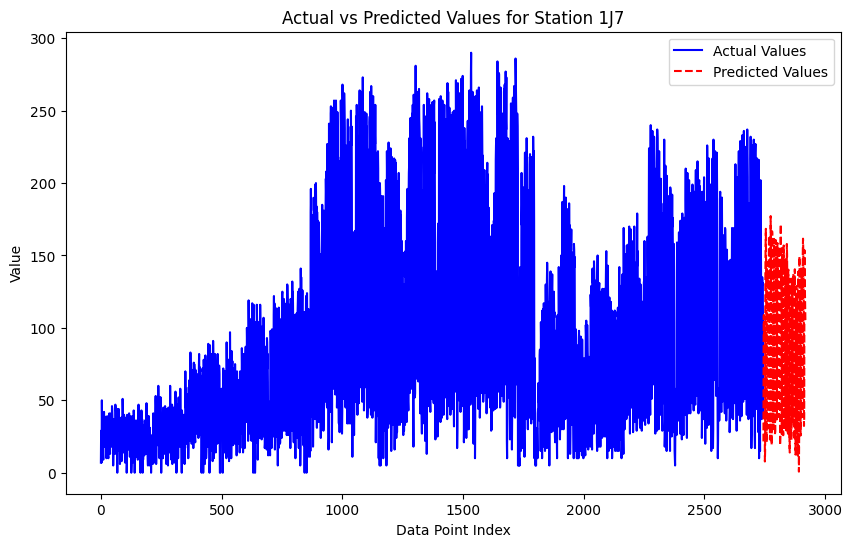

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

idx = 1
y_test = create_y_test(x_test) # You'll need to adjust this part based on how you've implemented create_y_test
for name_station, df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df['y']
    X_test_station = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    X_test_station_np = X_test_station.values

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=14)

    # Parameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
    }

    # Initialize XGBoost with fixed parameters not being tuned
    model = XGBRegressor(objective='reg:squarederror')

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_station_np, y_train_station_np)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_test_station_np)
    y_pred = np.where(y_pred < 0, 1, y_pred)  # Ensure no negative predictions

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

    # Generate an x-axis for y_train_station_np and y_pred for plotting
    x_axis_train = range(len(y_train_station_np))
    x_axis_pred = range(len(y_train_station_np), len(y_train_station_np) + len(y_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_axis_train, y_train_station_np, label='Actual Values', color='blue')
    plt.plot(x_axis_pred, y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this break to apply the model to all stations

y_test.to_csv(f'{name_station}_predictions.csv', index=False)


----
## <b> 4: AdaBoost </b>

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Initialize lists to store metrics or any other performance measures if needed
metrics = []

# Train the model for each station
idx = 1
for name_station in y_array:  
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    # Select data for the current station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]

    # Define the base estimator
    base_estimator = DecisionTreeRegressor(max_depth=100)

    # Initialize the AdaBoost model
    # Note: The number of estimators, learning rate, and loss function can be tuned
    model = AdaBoostRegressor(base_estimator=base_estimator, n_estimators=140, learning_rate=0.01, loss='linear')

    # Train the model
    model.fit(X_train_station, y_train_station)

    # Predict
    predictions = model.predict(X_test_station)

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_AdaBoost_BIG.csv', index=False)


----
## <b> 5: LightGBM </b>

In [ ]:
import lightgbm as lgb

# Initialize lists to store metrics or any other performance measures if needed
metrics = []

# Train the model for each station
idx = 1
for name_station in y_array:
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    # Select data for the current station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]

    # Initialize datasets for LightGBM
    train_data = lgb.Dataset(X_train_station, label=y_train_station)

    # Define LightGBM parameters
    params = {
        'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
        'objective': 'regression',
        'metric': 'rmse',  # Root Mean Square Error
        'num_leaves': 31,  # Number of leaves in one tree
        'learning_rate': 0.01,
        'feature_fraction': 0.9,  # The fraction of features to be used for each tree
        'bagging_fraction': 0.8,  # The fraction of data to be used for each tree
        'bagging_freq': 5,  # Frequency for bagging
        'verbose': -1  # <0 = Fatal, =0 = Error (Warn), >0 = Info
    }

    # Number of boosting rounds
    num_rounds = 140

    # Train the model
    bst = lgb.train(params, train_data, num_rounds)

    # Predict
    predictions = bst.predict(X_test_station)

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_LightGBM.csv', index=False)


----
## <b> 6: Ensemble Learning </b>

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt

idx = 1
for name_station,df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df_per_station[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df_per_station[str(name_station)]['y']
    X_test_station = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    print(type(X_train_station))
    print(type(y_train_station))

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    X_test_station_np = X_test_station.values

    print(X_train_station_np.shape)
    print(y_train_station_np.shape)
    print(X_test_station_np.shape)

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=14)

    # Parameter grid for ElasticNet
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9, 1.5],
        'max_iter':[4000, 10000, 100000],
        'tol': [0.01, 0.05, 0.10, 0.20, 0.001, 0.0001 ]
    }

    # Initialize ElasticNet with fixed parameters not being tuned
    model = ElasticNet()

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_station_np, y_train_station_np)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_test_station_np)
    y_pred = np.where(y_pred < 0, 1, y_pred)

    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred

y_test.to_csv(f'{name_station}_predictions.csv', index=False)



In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Model configurations
models = {
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.5, 0.9, 1.5],
            'max_iter': [4000, 10000, 100000],
            'tol': [0.01, 0.05, 0.10, 0.20, 0.001, 0.0001]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(objective='reg:squarederror'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [6, 10, 15],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    },
    'LGBM': {
        'model': LGBMRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.5],
            'num_leaves': [31, 62, 127],
            'boosting_type': ['gbdt', 'dart']
        }
    }
}

# Set up Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=14)

idx = 1
results = []

for name_station, df in df_per_station.items():
    print(f"Station {name_station}, idx: {idx}/439")
    idx += 1

    X_train_station = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_train_station = df['y']
    X_test_station = df_per_station_test[name_station][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    X_test_station_np = X_test_station.values

    for model_name, config in models.items():
        grid_search = GridSearchCV(
            config['model'], config['params'], cv=tscv,
            scoring='neg_mean_absolute_percentage_error', verbose=1
        )

        # Fit GridSearchCV
        grid_search.fit(X_train_station_np, y_train_station_np)

        # Best model from grid search
        best_model = grid_search.best_estimator_

        # Prediction using the best model
        y_pred = best_model.predict(X_test_station_np)
        y_pred = np.where(y_pred < 0, 1, y_pred)  # Ensure no negative predictions

        y_test.loc[y_test['index'].str.contains(name_station), model_name] = y_pred

        print(f"Best parameters for {model_name}: {grid_search.best_params_}")

    break

y_test.to_csv(f'{name_station}_predictions.csv', index=False)


Station 1J7, idx: 1/439
Fitting 14 folds for each of 288 candidates, totalling 4032 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1008 fits failed out of a total of 4032.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1008 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py", line 892, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

----
## <b> 6: ARIMAX </b>

----
----
# <b> LSTM LOL </b>

In [ ]:
X_test = df_per_station_test['1J7'][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]


In [ ]:
print(X_test.head())

       job  ferie  vacances  day_of_week_cos  day_of_week_sin  day_of_year  \
0        0      1         1         0.623490        -0.781831            1   
2612     1      0         1         1.000000         0.000000            2   
5231     1      0         0         0.623490         0.781831            3   
7855     1      0         0        -0.222521         0.974928            4   
10467    1      0         0        -0.900969         0.433884            5   

       day_of_month  day_of_week  
0                 1            7  
2612              2            1  
5231              3            2  
7855              4            3  
10467             5            4  


In [ ]:
print(y_pred_actual)

[[0.276797  ]
 [0.25325835]
 [0.30802086]
 [0.11829461]
 [0.12677374]
 [0.49059486]
 [0.4874667 ]
 [0.4256011 ]
 [0.45829552]
 [0.40742368]
 [0.12279351]
 [0.13317057]
 [0.5667406 ]
 [0.5279844 ]
 [0.4482295 ]
 [0.47998613]
 [0.4388522 ]
 [0.12350769]
 [0.14439547]
 [0.5203522 ]
 [0.5047763 ]
 [0.39608377]
 [0.40471366]
 [0.4141533 ]
 [0.11594841]
 [0.14285746]
 [0.3151328 ]
 [0.3516221 ]
 [0.29651505]
 [0.23476794]
 [0.3798774 ]
 [0.12679633]
 [0.13980411]
 [0.54825133]
 [0.49267048]
 [0.53920794]
 [0.49787748]
 [0.3913002 ]
 [0.13377097]
 [0.15367725]
 [0.53861934]
 [0.5204995 ]
 [0.42875236]
 [0.2519816 ]
 [0.21971583]
 [0.1171266 ]
 [0.12076865]
 [0.4200418 ]
 [0.37519717]
 [0.32626364]
 [0.35201937]
 [0.2772705 ]
 [0.14811349]
 [0.13738456]
 [0.71859807]
 [0.5117845 ]
 [0.5528768 ]
 [0.46190304]
 [0.5551414 ]
 [0.13111016]
 [0.18472588]
 [0.884531  ]
 [0.7150295 ]
 [0.81916493]
 [0.43058532]
 [0.39502698]
 [0.1605804 ]
 [0.20540112]
 [0.578146  ]
 [0.53593266]
 [0.49783474]
 [0.41

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create sequences from the dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    dftest = df_per_station_test[str(name_station)].items()
    X_test = dftest[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]


    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
    X_test_scaled = scaler.transform(X_test)  # Use the same scaler as the training set

    time_steps = 10
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)
    X_test_seq, _ = create_dataset(pd.DataFrame(X_test_scaled),  pd.DataFrame(np.zeros_like(y_scaled)), time_steps)

    # Enhanced Model Definition
    #model = Sequential([
    #    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    #    Dropout(0.3),
    #    LSTM(256, return_sequences=True),
    #    Dropout(0.3),
    #    LSTM(128, return_sequences=False),
    #    Dense(64, activation='relu'),
    #    Dropout(0.3),
    #    Dense(1)
    #])

    # Hybrid CNN-LSTM Model Definition
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])


    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_seq, y_seq, epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_test_seq)
    y_pred_actual = scaler.inverse_transform(y_pred)

    plt.figure(figsize=(10, 6))
    #plt.plot(y, label='Actual Values', color='blue')
    plt.plot(y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Enhanced Model Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    print(type(y_pred_actual))
    #y_test.loc[y_test['index'].str.contains(name_station), 'y'] = y_pred_actual

    # Save y_test dataframe to a csv file
    #y_test.to_csv('/kaggle/working/y_deep_Kaggle_BI.csv', index=False)
    break
    idx +=1
    if idx > 2:
        break



Station 1J7


TypeError: 'generator' object is not subscriptable

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']
    X_test = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y_test_g = df_per_station_test[str(name_station)]['y']

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
    X_test_scaled = scaler.transform(X_test)

    time_steps = 10
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)
    X_test_seq, _ = create_dataset(pd.DataFrame(X_test_scaled), pd.DataFrame(X_test_scaled), time_steps) # Dummy y just to match function

    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_seq, y_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_test_seq)
    y_pred_actual = scaler.inverse_transform(y_pred)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


    y_test_g = pd.DataFrame(y_test_g).reset_index(drop=True)  
    y_test_g['Predicted'] = pd.Series(y_pred_actual.flatten())

    y_test_g.to_csv(f'{name_station}_predictions.csv', index=False)

    idx += 1
    if idx > 2:  # Limit to 2 iterations for demonstration
        break


Station 1J7


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: X has 8 features, but MinMaxScaler is expecting 1 features as input.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']
    X_test = df_per_station_test[str(name_station)][['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
    X_test_scaled = scaler.transform(X_test)  # Corrected to use transform()

    time_steps = 10
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)
    X_test_seq, _ = create_dataset(pd.DataFrame(X_test_scaled), pd.DataFrame(np.zeros_like(y_scaled)), time_steps)  # Dummy y for compatibility

    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_seq.shape[1], X_seq.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_seq, y_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_test_seq)
    y_pred_actual = scaler.inverse_transform(y_pred)  
    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_actual, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Predicted Values for Station {name_station}')
    plt.xlabel('Sequence')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Additional steps to save or further process y_pred_actual as needed
    break  # If you're iterating over stations but only want to process one for demonstration


Station 1J7


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: X has 8 features, but MinMaxScaler is expecting 1 features as input.

----
----
## <b> STEP 8: Do a XGBOOST / LGBMRegressor - VALIDATION </b>

----
## <b> 8.2: LGBMREGRESSOR </b>

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

# Train the model for each station
idx = 1
for name_station in df_per_station.keys():
    print(f"Station{idx}")
    idx += 1

    X_train_station = X_train_test[data['station'] == name_station]
    y_train_station = y_train_test[data['station'] == name_station]
    X_val_station = X_val[data['station'] == name_station]
    y_val_station = y_val[data['station'] == name_station]

    # Initialize the XGBoost regressor
    model = LGBMRegressor(n_estimators=50, random_state=42)

    # Fit the model on the training data
    model.fit(X_train_station, y_train_station)

    # Predict on the validation set
    y_pred = model.predict(X_val_station)

    # Calculate the score
    score = mean_absolute_percentage_error(y_val_station, y_pred)
    print(score)


Station1
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(2745, 5)
(2745,)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20
[LightGBM] [Info] Number of data points in the train set: 2196, number of used features: 5
[LightGBM] [Info] Start training from score 106.196266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
0        349
423      587
848     1325
1272    1421
1698     182
Name: y, dtype: int64
1914901261544775.5


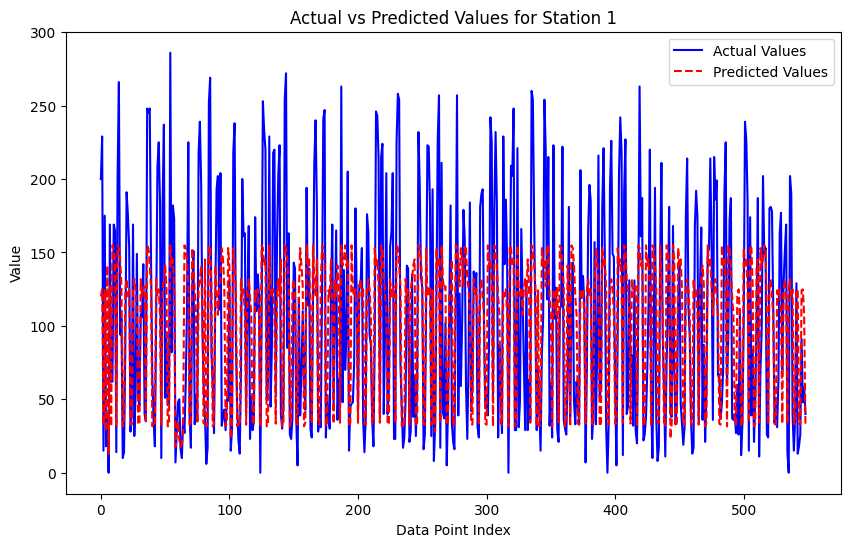

In [ ]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error

idx = 1
for name_station in df_per_station.keys():
    print(f"Station{idx}")
    idx += 1

    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    print(type(X_train_station))
    print(type(y_train_station))
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    print(X_train_station_np.shape)
    print(y_train_station_np.shape)

    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.2, shuffle = False)


    model = LGBMRegressor(n_estimators=2)
    model.fit(X_train_run, y_train_run)
    y_pred = base_model.predict(X_val_run)
    #print(y_pred)
    print(y_val_station.head())
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(score)


    # Plotting actual vs predicted values without sorting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this if you want to plot for all stations


----
----
# <b> STEP 9: Define X_TEST and Y_TEST </b>

## <b> 9.1: Define X_test </b>

In [ ]:
x_test['date'] = pd.to_datetime(x_test['date'])
x_test['day_of_week'] = x_test['date'].dt.dayofweek + 1
print(x_test.head())
x_test['day_of_week_cos'] = np.cos(2 * np.pi * (x_test['day_of_week'] - 1) / 7)
x_test['day_of_week_sin'] = np.sin(2 * np.pi * (x_test['day_of_week'] - 1) / 7)
X_test = x_test[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin']]

            index       date station  job  ferie  vacances  day_of_week
0  2023-01-01_1J7 2023-01-01     1J7    0      1         1            7
1  2023-01-01_O2O 2023-01-01     O2O    0      1         1            7
2  2023-01-01_8QR 2023-01-01     8QR    0      1         1            7
3  2023-01-01_L58 2023-01-01     L58    0      1         1            7
4  2023-01-01_UMC 2023-01-01     UMC    0      1         1            7


----
----
# <b> STEP 10: Prophet FACEBOOK </b>

In [ ]:
!pip install pystan


In [ ]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
Using cached cmdstanpy-0.9.5-py3-none-any.whl (37 kB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [42 lines of output]
      /tmp/pip-install-l6yybcgi/fbprophet_6cb811f6f11c4c4a932c3d7dbbfa1da5/setup.py:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
        from pkg_resources import (
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-l6yybcgi/fbprophet_6cb811f6f11c4c4a932c3d7dbbfa1da5/setup.py", line 122, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/__init__.py", line 103, in setup
          return distutils.co

In [ ]:
entry = data[['date','y']]
print(entry.head())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Train the model for each station
idx = 1
for name_station in y_array:
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    X_train_station = entry[data['station'] == name_station].values.astype(float)
    m = Prophet()
    m.fit(X_train_station)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(periods=365)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = forecast[['yhat']]

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_deep_Kaggle_VCOMPLEX.csv', index=False)



In [ ]:
from fbprophet import Prophet

# Initialize a list to store metrics or any other performance measures if needed
metrics = []


idx = 1
for name_station in y_array: 
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    # Select data for the current station
    train_data = data[data['station'] == name_station][['ds', 'y']]  # Training data
    test_data = x_test[x_test['station'] == name_station][['ds']]  # Test data dates

    # Initialize and configure the Prophet model
    # Note: You might want to tune these parameters
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive'
    )

    # Fit the model
    model.fit(train_data)

    # Make a future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data), freq='D')  # 'D' for daily frequency, adjust as necessary

    # Predict
    forecast = model.predict(future)

    # Extract the predicted values for the test set dates
    predictions = forecast.loc[forecast['ds'].isin(test_data['ds']), 'yhat'].values

    y_test.loc[(y_test['station'] == name_station) & (y_test['ds'].isin(test_data['ds'])), 'y'] = predictions

    # Optional: Calculate and store performance metrics, e.g., RMSE
    # You'd need the actual values for the test set to calculate RMSE or other metrics

# Save the updated y_test dataframe with predictions
y_test.to_csv('/kaggle/working/y_prophet_Kaggle_BI.csv', index=False)


In [ ]:
from fbprophet import Prophet
import pandas as pd

# Ensure y_test is prepared to receive the forecast values

for name_station in y_array:
    print(f"Processing station {name_station}")

    X_train_station = entry[entry['station'] == name_station]

    m = Prophet()
    m.fit(X_train_station)

    # Make future dataframe for 365 days
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)

    # Extract the last 365 'yhat' values
    predicted_values = forecast['yhat'][-365:]

    # Find the indexes in y_test that correspond to this station's last 365 days
    indexes_to_update = y_test[(y_test['station'] == name_station)].tail(365).index

    # Update y_test only for the last 365 values for the current station
    y_test.loc[indexes_to_update, 'y'] = predicted_values.values

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_deep_Kaggle_PROPHET.csv', index=False)


In [ ]:
from fbprophet import Prophet

# Initialize a list to store metrics or any other performance measures if needed
metrics = []

idx = 1
for name_station in y_array:
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    # Select data for the current station
    train_data = data[data['station'] == name_station]
    test_data = x_test[x_test['station'] == name_station]

    # Prepare the data for Prophet
    train_data_for_prophet = train_data[['ds', 'y', 'ferie', 'job', 'vacances']]  
    test_data_for_prophet = test_data[['ds', 'ferie', 'job', 'vacances']]

    # Initialize the Prophet model
    model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True, seasonality_mode='additive')

    # Add extra regressors
    model.add_regressor('ferie')
    model.add_regressor('job')
    model.add_regressor('vacances')

    # Fit the model
    model.fit(train_data_for_prophet)

    # Make a future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data), freq='D')  # Adjust 'D' as necessary for your data's frequency

    # Merge the future dataframe with the extra regressors from the test dataset
    future = future.merge(test_data_for_prophet, on='ds', how='left')

    # Predict
    forecast = model.predict(future)

    # Extract the predicted values for the test set dates
    predictions = forecast.loc[forecast['ds'].isin(test_data_for_prophet['ds']), 'yhat'].values

    # Update y_test dataframe with the predictions
    y_test.loc[(y_test['station'] == name_station) & (y_test['ds'].isin(test_data_for_prophet['ds'])), 'y'] = predictions

    # Optional: Calculate and store performance metrics

# Save the updated y_test dataframe with predictions
y_test.to_csv('/kaggle/working/y_prophet_with_regressors_Kaggle_BI.csv', index=False)


ModuleNotFoundError: No module named 'fbprophet'

----
----
# <b> STEP 11: BOOSTING - ON TEST </b>

## <b> ElasticNet Linear Regression </b>

In [ ]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 2.5 MB/s eta 0:00:00


Station 1J7
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(2745, 5)
(2745,)
Fitting 31 folds for each of 144 candidates, totalling 4464 fits
MAPE Score: 2319700645325055.5


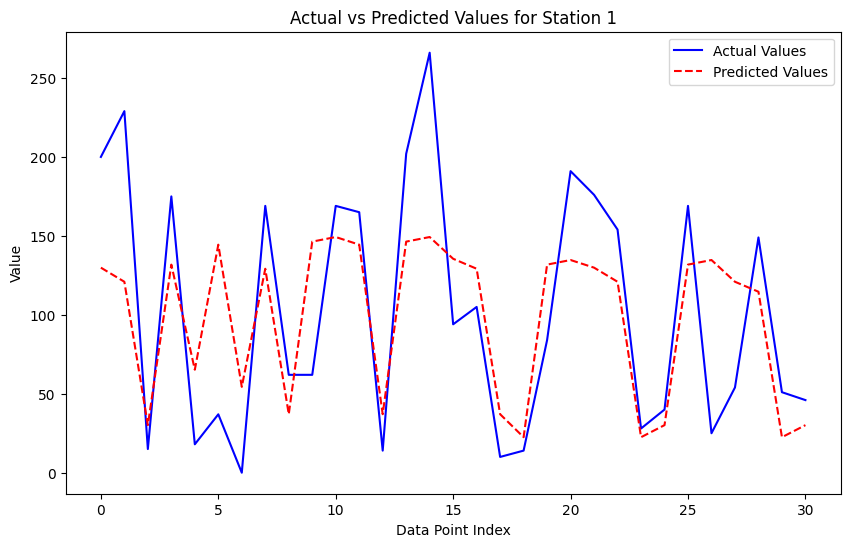

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split
import tsfel



idx = 1
for name_station in df_per_station.keys():
    print(f"Station {name_station}")
    idx += 1

    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]

    print(type(X_train_station))
    print(type(y_train_station))

    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values

    print(X_train_station_np.shape)
    print(y_train_station_np.shape)

    # Splitting the station-specific data for training and validation
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(
        X_train_station_np, y_train_station_np, test_size=0.2, shuffle=False)


    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=31)

    # Parameter grid for ElasticNet
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter':[10000, 100000],
        'tol': [0.01, 0.05, 0.10, 0.20, 0.001, 0.0001 ]
    }

    # Initialize ElasticNet with fixed parameters not being tuned
    model = ElasticNet()

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_run, y_train_run)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_val_run)

    # Evaluation
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"MAPE Score: {score}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run[:31], label='Actual Values', color='blue')
    plt.plot(y_pred[:31], label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this to process all stations


In [ ]:

# Load TSFEL feature extraction configuration
cfg = tsfel.get_features_by_domain()

# Loop through each station
for name_station in df_per_station.keys():
    print(f"Processing Station {name_station}")

    # Filter X_train and y_train for the current station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]

    # Ensure data is in NumPy array format for TSFEL
    X_train_station_np = np.array(X_train_station)
    print(X_train_station_np.shape)
    y_train_station_np = np.array(y_train_station)

    # Feature extraction with TSFEL
    X_train_station_feat = tsfel.time_series_features_extractor(cfg, X_train_station_np)
    print(X_train_station_feat.shape)

    # Splitting the data for training and validation
    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(
        X_train_station_feat, y_train_station_np, test_size=0.2, shuffle=False)

    # Set up Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)  # Adjust based on your dataset size and temporal resolution

    # Parameter grid for ElasticNet
    param_grid = {
        'alpha': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.9]
    }

    # Initialize ElasticNet with fixed parameters not being tuned
    model = ElasticNet(max_iter=10000, random_state=42)

    # GridSearchCV setup
    grid_search = GridSearchCV(
        model, param_grid, cv=tscv,
        scoring='neg_mean_absolute_percentage_error', verbose=1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train_run, y_train_run)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Prediction using the best model
    y_pred = best_model.predict(X_val_run)

    # Evaluation
    score = mean_absolute_percentage_error(y_val_run, y_pred)
    print(f"MAPE Score for Station {name_station}: {score:.4f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this to process all stations


Processing Station 1J7
(2745, 5)
*** Feature extraction started ***


/tmp/ipykernel_34/272240670.py:29: UserWarning: Using default sampling frequency set in configuration file.
  X_train_station_feat = tsfel.time_series_features_extractor(cfg, X_train_station_np)



*** Feature extraction finished ***
(1, 1945)


ValueError: Found input variables with inconsistent numbers of samples: [1, 2745]

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, train_test_split


cfg = tsfel.get_features_by_domain()

# Loop over the station names
for name_station in df_per_station.keys():
    print(f"Processing station {name_station}")

    # Filtering X_train and y_train by station
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]

    # Ensure X_train_station does not include the 'station' column

    # Extracting features from y_train_station using TSFEL
    # Reshape y_train_station to 2D array as required by tsfel
    y_features = tsfel.time_series_features_extractor(cfg, y_train_station.values.reshape(-1, 1), fs=1)

    # Concatenate the newly extracted features with the existing features in X_train_station
    X_train_enhanced = pd.concat([X_train_station.reset_index(drop=True), y_features.reset_index(drop=True)], axis=1)

    # Convert to NumPy arrays for model compatibility
    X_train_enhanced_np = X_train_enhanced.to_numpy()
    y_train_station_np = y_train_station.to_numpy().ravel()  # Flatten if it's not a 1D array already

    # Split the data into training and validation sets
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train_enhanced_np, y_train_station_np, test_size=0.2, shuffle=False)

    # Time series cross-validation
    tscv = TimeSeriesSplit(n_splits=5)

    # ElasticNet model and GridSearchCV
    model = ElasticNet()
    param_grid = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.5, 0.9]}
    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring='neg_mean_absolute_percentage_error', verbose=1)

    # Fit the grid search to the data
    grid_search.fit(X_train_split, y_train_split)

    # Get the best model from grid search
    best_model = grid_search.best_estimator_

    # Predict on the validation set
    y_pred = best_model.predict(X_val_split)

    # Calculate MAPE
    mape_score = mean_absolute_percentage_error(y_val_split, y_pred)
    print(f"MAPE for station {name_station}: {mape_score}")

    # Plot the actual vs predicted attendance
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_split, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', linestyle='--', color='red')
    plt.title(f'Actual vs Predicted Attendance for {name_station}')
    plt.xlabel('Time')
    plt.ylabel('Attendance')
    plt.legend()
    plt.show()

    # Break after the first station for demonstration; remove this to process all stations
    break


Processing station 1J7
*** Feature extraction started ***



*** Feature extraction finished ***
Fitting 5 folds for each of 12 candidates, totalling 60 fits


ValueError: 
All the 60 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py", line 908, in fit
    X, y = self._validate_data(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 921, in check_array
    _assert_all_finite(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
ElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


----
----
# <b> STEP 11: Now let's do Deep Learning ! </b>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to create sequences from the dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Example station data initialization
# Ensure df_per_station is initialized with your actual data

idx = 1
for name_station, df in df_per_station.items():
    print(f"Station {name_station}")

    X = df[['job', 'ferie', 'vacances', 'day_of_week_cos', 'day_of_week_sin', 'day_of_year', 'day_of_month', 'day_of_week']]
    y = df['y']

    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    time_steps = 10
    X_seq, y_seq = create_dataset(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), time_steps)


    # Enhanced Model Definition
    #model = Sequential([
    #    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    #    Dropout(0.3),
    #    LSTM(256, return_sequences=True),
    #    Dropout(0.3),
    #    LSTM(128, return_sequences=False),
    #    Dense(64, activation='relu'),
    #    Dropout(0.3),
    #    Dense(1)
    #])

    # Hybrid CNN-LSTM Model Definition
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=128, kernel_size=2, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(256, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1)
    ])


    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(X_seq, y_seq, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    y_pred = model.predict(X_test)
    y_pred_actual = scaler.inverse_transform(y_pred)
    predictions = outputs.numpy().flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(y, label='Actual Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Enhanced Model Actual vs Predicted Values for Station {name_station}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_deep_Kaggle_BI.csv', index=False)

----
## <b> 1/ Simple LSTM + FC </b>
## <b> 2/ Bidirectional LSTM </b>
## <b> 3/ Complex LSTM + FC </b>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the neural network architecture
class TimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TimeSeriesRegression, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.fc(output)

        return output


class EvolvedTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.1):
        super(EvolvedTimeSeriesRegression, self).__init__()
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate if num_layers > 1 else 0, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)

        # More complex FC network with Batch Normalization
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Adjust for bidirectional output
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x):
        output, _ = self.lstm(x)
        # Apply dropout
        output = self.dropout(output)
        # Select the output of the last time step
        # output = output[:, -1, :]
        output = F.relu(self.fc1(output))
        output = self.dropout(F.relu(self.fc2(output)))
        output = self.fc3(output)

        return output

# Define the neural network architecture
class VComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VComplexTimeSeriesRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output = self.fc1(x)
        output = self.fc2(output)
        output = self.fc3(output)
        return output


# Define the neural network architecture
class ComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ComplexTimeSeriesRegression, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, 2*hidden_size, num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(2*hidden_size, hidden_size, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 2*hidden_size)
        self.fc3 = nn.Linear(2*hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm1(x)
        output, _ = self.lstm2(output)
        output, _ = self.lstm3(output)
        output, _ = self.lstm4(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        output = self.fc4(output)

        return output

import torch.nn as nn
import torch.nn.functional as F

class UltraComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(UltraComplexTimeSeriesRegression, self).__init__()
        # First fully connected layer
        self.initial_fc = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers,
                            dropout=dropout_rate, bidirectional=True, batch_first=True)

        # Additional fully connected layers with residual connections
        self.fc_layers = nn.ModuleList()
        for _ in range(2):  # Adding two more dense layers
            self.fc_layers.append(nn.Linear(2*hidden_size, 2*hidden_size))  # Factor of 2 for bidirectional output
            self.fc_layers.append(nn.BatchNorm1d(2*hidden_size))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(dropout_rate))

        self.final_fc = nn.Linear(2*hidden_size, 1)  # Output layer

    def forward(self, x):
        # Initial processing
        x = self.relu(self.batch_norm1(self.initial_fc(x)))

        # LSTM layer
        x, _ = self.lstm(x)

        # Apply residual connections in fully connected layers
        identity = x
        for i, layer in enumerate(self.fc_layers):
            if i % 4 == 0 and i != 0:  # Every 4th layer (except the first time) add residual connection
                identity = x
            x = layer(x)
            if (i - 2) % 4 == 0:  # After ReLU
                x += identity  # Add the residual connection

        # Final layer
        x = self.final_fc(x)

        return x


# Define the loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.001
num_epochs = 130

# Create an instance of the model
hidden_size = 128
num_layers = 4




# Train the model for each station
idx = 1
for name_station in y_array:
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    X_test_station = X_test[x_test['station'] == name_station]

    # Convert the data to PyTorch tensors
    X_train_tensor_station = torch.tensor(X_train_station.values,dtype=torch.float32)

    # input_size = X_train_tensor_station.shape[0]
    input_size = X_train_tensor_station.shape[1]

    X_train_tensor_station = torch.tensor(X_train_station.values,dtype=torch.float32).to(device)
    X_train_tensor_station = X_train_tensor_station.t()
    print(X_train_tensor_station.shape)
    y_train_tensor_station = torch.tensor(y_train_station.values,dtype=torch.float32).to(device)
    X_test_tensor_station = torch.tensor(X_test_station.values,dtype=torch.float32).to(device)

    input_size = X_train_tensor_station.shape[0]
    # model = ComplexTimeSeriesRegression(input_size, hidden_size, num_layers)
    # model = TimeSeriesRegression(input_size, hidden_size, num_layers)
    model = VComplexTimeSeriesRegression(input_size, hidden_size).to(device)
    #model = UltraComplexTimeSeriesRegression(input_size, hidden_size, num_layers).to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor_station)
        loss = criterion(outputs, y_train_tensor_station.unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Evaluate the model
    with torch.no_grad():
        outputs = model(X_test_tensor_station)
        predictions = outputs.numpy().flatten()

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_deep_Kaggle_BI.csv', index=False)



station:1/439
torch.Size([5, 2898])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the neural network architecture
class ComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ComplexTimeSeriesRegression, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 2*hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(2*hidden_size,4*hidden_size, num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(4*hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
        self.fc2 = nn.Linear(2*hidden_size, 4*hidden_size)
        self.fc3 = nn.Linear(4*hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm1(x)
        output, _ = self.lstm2(output)
        output, _ = self.lstm3(output)
        output, _ = self.lstm4(output)
        output = output[:, -1, :]
        output = F.relu(self.fc1(output))
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        output = self.fc4(output)
        return output

class UltraComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(UltraComplexTimeSeriesRegression, self).__init__()
        # First fully connected layer
        self.initial_fc = nn.Linear(input_size, hidden_size)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()

        # Bidirectional LSTM layer
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers,
                            dropout=dropout_rate, bidirectional=True, batch_first=True)

        # Additional fully connected layers with residual connections
        self.fc_layers = nn.ModuleList()
        for _ in range(2):  # Adding two more dense layers
            self.fc_layers.append(nn.Linear(2*hidden_size, 2*hidden_size))  # Factor of 2 for bidirectional output
            self.fc_layers.append(nn.BatchNorm1d(2*hidden_size))
            self.fc_layers.append(nn.ReLU())
            self.fc_layers.append(nn.Dropout(dropout_rate))

        self.final_fc = nn.Linear(2*hidden_size, 1)  # Output layer

    def forward(self, x):
        # Initial processing
        x = self.relu(self.batch_norm1(self.initial_fc(x)))

        # LSTM layer
        x, _ = self.lstm(x)

        # Apply residual connections in fully connected layers
        identity = x
        for i, layer in enumerate(self.fc_layers):
            if i % 4 == 0 and i != 0:  # Every 4th layer (except the first time) add residual connection
                identity = x
            x = layer(x)
            if (i - 2) % 4 == 0:  # After ReLU
                x += identity  # Add the residual connection

        # Final layer
        x = self.final_fc(x)

        return x

class ComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ComplexTimeSeriesRegression, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 2*hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(2*hidden_size,4*hidden_size, num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(4*hidden_size, 1, num_layers, batch_first=True)
        self.fc1 = nn.Linear(input_size, 2*hidden_size)
        self.fc2 = nn.Linear(2*hidden_size, 4*hidden_size)
        self.fc3 = nn.Linear(4*hidden_size, 8 *hidden_size)
        self.fc4 = nn.Linear(8*hidden_size, 4*hidden_size)
        self.fc5 = nn.Linear(4*hidden_size, 2*hidden_size)
        self.fc6 = nn.Linear(2*hidden_size, 1)

    def forward(self, x):
        #x = x[:, -1, :]
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = F.relu(self.fc5(output))
        output = self.fc6(output)
        return output
# Define the loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.0001
num_epochs = 1001

# Create an instance of the model
hidden_size = 512
num_layers = 2
input_size = 5

# Train the model for each station
idx = 1
for name_station in y_array:
    print(f"station:{idx}/{len(y_array)}")
    idx += 1

    X_train_station = X_train[data['station'] == name_station].values.astype(float)
    y_train_station = y_train[data['station'] == name_station].values.astype(float)
    X_test_station = X_test[x_test['station'] == name_station].values.astype(float)

    # Convert the data to PyTorch tensors and move to the device
    X_train_tensor = torch.tensor(X_train_station, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_station, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_station, dtype=torch.float32).to(device)

    # Reshape input tensors to have the correct shape
    X_train_tensor = X_train_tensor.view(-1, 1, input_size)  # Reshape for LSTM: [batch_size, seq_len, input_size]
    print(X_train_tensor.shape)
    X_test_tensor = X_test_tensor.view(-1, 1, input_size)

    model = ComplexTimeSeriesRegression(input_size, hidden_size, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor.unsqueeze(1))
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:  # Print loss every 10 epochs
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Evaluate the model
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = outputs.squeeze().cpu().numpy()

    # Update the y_test dataframe with the predictions
    y_test.loc[y_test['index'].str.contains(name_station), 'y'] = predictions

# Save y_test dataframe to a csv file
y_test.to_csv('/kaggle/working/y_deep_Kaggle_VCOMPLEX.csv', index=False)



station:1/439
torch.Size([2898, 1, 5])
Epoch 1/1001, Loss: 119371.3515625
Epoch 101/1001, Loss: 32542.97265625
Epoch 201/1001, Loss: 32498.0078125
Epoch 301/1001, Loss: 32495.580078125
Epoch 401/1001, Loss: 32495.365234375
Epoch 501/1001, Loss: 32495.345703125
Epoch 601/1001, Loss: 32495.333984375
Epoch 701/1001, Loss: 32495.326171875
Epoch 801/1001, Loss: 32495.3203125
Epoch 901/1001, Loss: 32495.31640625
Epoch 1001/1001, Loss: 32495.314453125
station:2/439
torch.Size([2907, 1, 5])
Epoch 1/1001, Loss: 20280294.0
Epoch 101/1001, Loss: 4986102.5
Epoch 201/1001, Loss: 4957075.0
Epoch 301/1001, Loss: 4953544.5


KeyboardInterrupt: 

Station1
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
(2832, 5)
(2832,)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([2265, 1])) that is different to the input size (torch.Size([2265, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/201, Loss: 825.349365234375
Epoch 101/201, Loss: 175.90643310546875
Epoch 201/201, Loss: 175.83480834960938
[25.476252 25.454718 25.469551 25.452202 25.498993 25.362942 25.462053
 25.467533 25.469551 25.372738 25.480772 25.870691 25.476252 25.462053
 25.472383 25.452202 25.480772 25.462053 25.469864 25.472383 25.452202
 25.434875 25.476252 25.462053 25.454718 25.469551 25.406143 25.498993
 25.362942 25.454718 25.467533 25.469551 25.406143 25.362942 25.479492
 25.454718 25.467533 25.406143 25.362942 25.476252 25.469864 25.472383
 25.452202 25.480772 25.476252 25.462053 25.469864 25.467533 25.406143
 25.498993 25.362942 25.479492 25.467533 25.469551 25.406143 25.480772
 25.476252 25.462053 25.469864 25.472383 25.480772 25.434875 25.476252
 25.575222 25.524176 25.542933 25.648853 25.575222 25.55642  25.524176
 25.472383 25.452202 25.434875 25.476252 25.462053 25.469864 25.452202
 25.480772 25.362942 25.479492 25.469864 25.469551 25.406143 25.480772
 25.479492 25.454718 25.434875 2

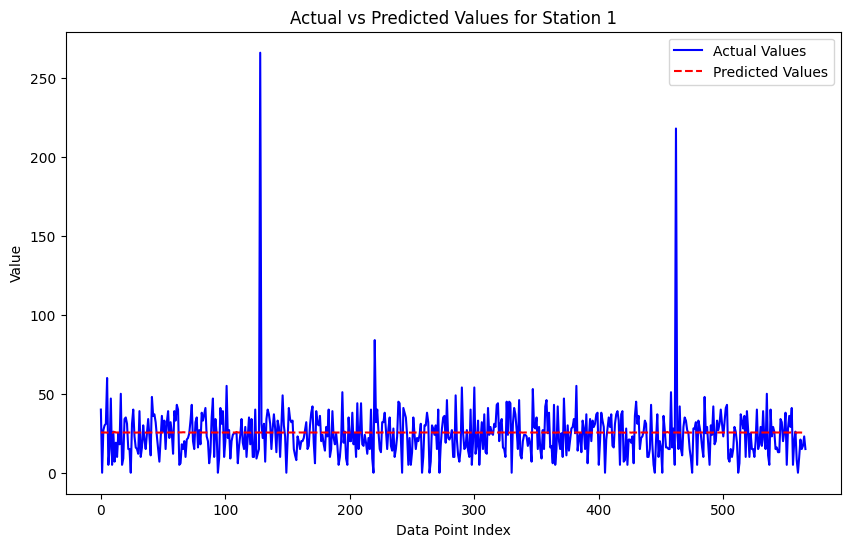

In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim

class ComplexTimeSeriesRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(ComplexTimeSeriesRegression, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, 2*hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(2*hidden_size,4*hidden_size, num_layers, batch_first=True)
        self.lstm4 = nn.LSTM(4*hidden_size, 1, num_layers, batch_first=True)
        self.fc1 = nn.Linear(input_size, 2*hidden_size)
        self.fc2 = nn.Linear(2*hidden_size, 4*hidden_size)
        self.fc3 = nn.Linear(4*hidden_size, 8 *hidden_size)
        self.fc4 = nn.Linear(8*hidden_size, 4*hidden_size)
        self.fc5 = nn.Linear(4*hidden_size, 2*hidden_size)
        self.fc6 = nn.Linear(2*hidden_size, 1)

    def forward(self, x):
        #x = x[:, -1, :]
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = F.relu(self.fc5(output))
        output = self.fc6(output)
        return output

# Define the loss function and optimizer
criterion = nn.MSELoss()
learning_rate = 0.0001
num_epochs = 201

# Create an instance of the model
hidden_size = 512
num_layers = 2
input_size = 5


idx = 1
for name_station in df_per_station.keys():
    print(f"Station{idx}")
    idx += 1
    name_station ='O2O'
    X_train_station = X_train[data['station'] == name_station]
    y_train_station = y_train[data['station'] == name_station]
    print(type(X_train_station))
    print(type(y_train_station))
    X_train_station_np = X_train_station.values
    y_train_station_np = y_train_station.values
    print(X_train_station_np.shape)
    print(y_train_station_np.shape)

    X_train_run, X_val_run, y_train_run, y_val_run = train_test_split(X_train_station_np, y_train_station_np, test_size=0.2, shuffle = False)

    X_train_run_tensor = torch.tensor(X_train_run, dtype=torch.float32).to(device)
    y_train_run_tensor = torch.tensor(y_train_run, dtype=torch.float32).to(device)
    X_val_run_tensor = torch.tensor(X_val_run, dtype=torch.float32).to(device)

    X_train_run_tensor = X_train_run_tensor.view(-1, 1, input_size)
    X_val_run_tensor = X_val_run_tensor.view(-1, 1, input_size)

    model = ComplexTimeSeriesRegression(input_size, hidden_size, num_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_run_tensor)
        loss = criterion(outputs, y_train_run_tensor.unsqueeze(1))
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:  # Print loss every 10 epochs
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Evaluate the model
    with torch.no_grad():
        outputs = model(X_val_run_tensor)
        y_pred = outputs.squeeze().cpu().numpy()

    print(y_pred)


    # Plotting actual vs predicted values without sorting
    plt.figure(figsize=(10, 6))
    plt.plot(y_val_run, label='Actual Values', color='blue')  # Access values directly
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values for Station {idx-1}')
    plt.xlabel('Data Point Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    break  # Remove this if you want to plot for all stations


----
----
# <b> STEP 12: TS